In [117]:
from accretion_functions import *
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz, solve_ivp
import os
import glob
from scipy.integrate import quad
from scipy.optimize import root_scalar
import mesa_reader as mr
import matplotlib.pyplot as plt
from mesa_reader import MesaData  # Si usas mesa_reader
import matplotlib.font_manager as fm
from matplotlib.ticker import MultipleLocator, LogLocator
from scipy.optimize import brentq
from scipy.optimize import root
import emcee

# Constants
number_of_points = int(500)  # How many rows do you want in your DataFrame
# Angular range in theta (theta=0 corresponds to the north pole and theta=pi/2 to the equator)
# For 1pi/6 < theta < 5pi/6 we treat a torus belt over a +/- 60º around the equator.
theta_initial = 0 * np.pi / 6
theta_final = 6 * np.pi / 6
avg_norm_factor, _ = quad(lambda theta: np.sin(theta), theta_initial, theta_final)

G = 6.67430e-8  # Gravitational constant in cgs units
M_sun = 1.989e33  # Solar mass in g
R_sun = 6.957e10  # Solar radius in cm

# K = 4.44540243e+14  # Polytropic constant K (K = N_n_value * G * R * M**(1/3) in cgs units
gamma = 5 / 3  # Adiabatic index
c = 2.99792458e10  # Speed of light in cgs

# Ruta absoluta a la fuente Quicksand-Regular.ttf
font_path = '/fs/phaethon/other0/gibran/fonts/Quicksand-Regular.ttf'

# Registrar la fuente
fm.fontManager.addfont(font_path)

# Configurar Matplotlib para usar Quicksand como fuente predeterminada
plt.rcParams['font.family'] = 'Quicksand'
plt.rcParams['font.sans-serif'] = ['Quicksand']  # Asegura que se use Quicksand si hay problemas con el nombre
plt.rcParams['text.usetex'] = False  # Usar mathtext en lugar de LaTeX para simplicidad y compatibilidad
plt.rcParams['mathtext.fontset'] = 'custom'  # Usar fuente personalizada para matemáticas
plt.rcParams['mathtext.rm'] = 'Quicksand'  # Fuente para texto romano
plt.rcParams['mathtext.it'] = 'Quicksand:italic'  # Fuente para cursiva
plt.rcParams['mathtext.bf'] = 'Quicksand:bold'  # Fuente para negrita

# Configurar tamaños de fuente predeterminados
plt.rcParams['font.size'] = 18  # Tamaño de fuente predeterminado
plt.rcParams['axes.labelsize'] = 18  # Tamaño de etiquetas de ejes
plt.rcParams['legend.fontsize'] = 14  # Tamaño de fuente en la leyenda
plt.rcParams['xtick.labelsize'] = 18  # Tamaño de etiquetas en ejes x
plt.rcParams['ytick.labelsize'] = 18  # Tamaño de etiquetas en ejes y
plt.rcParams['axes.titlesize'] = 22  # Tamaño de títulos

# Configurar ticks en todos los ejes (globalmente)
plt.rcParams['xtick.top'] = True  # Habilitar ticks superiores
plt.rcParams['xtick.bottom'] = True  # Habilitar ticks inferiores
plt.rcParams['ytick.right'] = True  # Habilitar ticks derechos
plt.rcParams['ytick.left'] = True  # Habilitar ticks izquierdos
plt.rcParams['xtick.direction'] = 'in'  # Ticks hacia el interior en x
plt.rcParams['ytick.direction'] = 'in'  # Ticks hacia el interior en y


In [118]:
# Definir parámetros dinámicos
mass = 20  # Masa en M_sun
rotation = 0.75  # Fracción crítica de rotación
eta_d = 0.2  # Valor dinámico para D
Z = "0.1" 
# Construir el nombre del modelo usando variables dinámicas
#model = f'{mass}M_W{rotation}_D{eta_d}'
model = f'{mass}M_W{rotation}_D{eta_d}_Z{Z}'

#Ruta base a los perfiles de MESA
#base_path = f'/fs/phaethon/other0/gibran/sim_results/Si28_5d-2_W9_D{eta_d:.1f}/'
base_path = f'/fs/phaethon/other0/gibran/sim_results/woosley/W0.75'

# Ruta fija para guardar las gráficas
output_path = '/fs/phaethon/other0/gibran/accretion/plots/woosley'
# Crear directorio de salida si no existe
os.makedirs(output_path, exist_ok=True)


# Construir la ruta de logs
#logs_dir = os.path.join(base_path, f'{int(mass)}M_W{rotation}_D{eta_d}')
logs_dir = os.path.join(base_path, f'{int(mass)}M_D{eta_d}_Z{Z}')

# Función para extraer el número de perfil
def get_profile_number(filename):
    num_str = filename.split('profile')[-1].split('.data')[0]
    return int(num_str)

# Encuentra y ordena los archivos 'profile*.data'
profile_files = glob.glob(os.path.join(logs_dir, 'profile*.data'))
profile_files.sort(key=get_profile_number)

# Verificar si hay archivos disponibles
if not profile_files:
    raise FileNotFoundError(f"No se encontraron archivos 'profile*.data' en {logs_dir}")

# Cargar el último perfil
latest_profile = profile_files[-1]
profile_data = MesaData(latest_profile)


In [119]:
radius_values = profile_data.radius * R_sun  # Convert R_sun a cm
rho_values = 10**profile_data.logRho  # Densidad en g/cm^3 (logarithmic to linear)
Omega_values = profile_data.omega  # Omega (rad/s)

rho_interpolated = interp1d(radius_values, rho_values, kind='cubic', fill_value="extrapolate")
Omega_interpolated = interp1d(radius_values, Omega_values, kind='cubic', fill_value="extrapolate")

def M_r(r):
    result, _ = quad(lambda r_prime: 4 * np.pi * r_prime**2 * rho_interpolated(r_prime), 1e6, r)
    return result


In [120]:
# Create an r grid from 1e7 cm to the maximum radius in the profile
r_min = 1e7  # Starting radius in cm
r_max = np.max(profile_data.radius * R_sun)  # Convert from solar radii to cm
r_values = np.logspace(np.log10(r_min), np.log10(r_max), number_of_points)  # 100 grid points
data = []

for r in r_values:
    rho_val = rho_interpolated(r)
    Omega_r_val = Omega_interpolated(r)
    M_r_val = M_r(r)
    
    data.append([r, rho_val, M_r_val, Omega_r_val])

df = pd.DataFrame(data, columns=['r', 'rho_r', 'M_r', 'Omega_r'])

df['Omega_k'] = np.sqrt(G * df['M_r'] / df['r']**3)

#df['tau'] = np.log(df['rho_r']).diff() / np.log(df['r']).diff()

# Guardar el DataFrame actualizado
output_data_path = f'Data/data_{model}.csv'
df.to_csv(output_data_path, index=False, float_format='%.8e')
print(f"Archivo guardado en: {output_data_path}")



/tmp/ipykernel_137187/478041829.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result, _ = quad(lambda r_prime: 4 * np.pi * r_prime**2 * rho_interpolated(r_prime), 1e6, r)


Archivo guardado en: Data/data_20M_W0.75_D0.2_Z0.1.csv


In [121]:
df = pd.read_csv(f'Data/data_{model}.csv')

# Extraer datos relevantes del perfil MESA
mass_enclosed = np.array(profile_data.mass)  # Masa en masas solares
log_j_rot = np.array(profile_data.log_j_rot)  # log del momento angular de rotación

# === INTERPOLACIÓN DE j_LSO ===

mass_interp = np.linspace(mass_enclosed.min(), mass_enclosed.max(), number_of_points)

# Definir la función de interpolación
interp_j_LSO_log = interp1d(mass_enclosed, log_j_rot, kind='linear', bounds_error=False, fill_value='extrapolate')

# Evaluar la interpolación en la malla de 1000 puntos
log_j_LSO_interp = interp_j_LSO_log(mass_interp)

# === GUARDAR EN EL DATAFRAME ===
# Cargar el DataFrame original
data_path = f"Data/data_{model}.csv"
df = pd.read_csv(data_path)

# Interpolar j_LSO para los valores de M_r en el DataFrame
df['j_LSO'] = 10 ** interp_j_LSO_log(df['M_r'] / M_sun) 
# Guardar el DataFrame actualizado
output_data_path = f'Data/data_{model}.csv'
df.to_csv(output_data_path, index=False, float_format='%.8e')
print(f"Archivo guardado en: {output_data_path}")

Archivo guardado en: Data/data_20M_W0.75_D0.2_Z0.1.csv


/tmp/ipykernel_137187/4205797213.py:23: RuntimeWarning: overflow encountered in power
  df['j_LSO'] = 10 ** interp_j_LSO_log(df['M_r'] / M_sun)


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


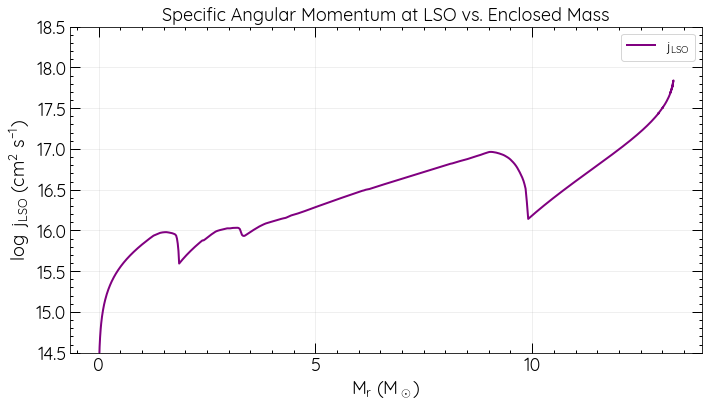

In [122]:
df = pd.read_csv(data_path)

# Graficar j_LSO vs M_r
plt.figure(figsize=(10, 6))
plt.plot(df['M_r'] / M_sun, np.log10((df['j_LSO'])), label=r"$j_{\rm LSO}$", color='purple', linestyle='-', linewidth=2)
plt.xlabel(r'$M_r$ ($M_\odot$)', fontsize=18)
plt.ylabel(r'$\log \ j_{\rm LSO}$ ($\rm cm^2\ s^{-1}$)', fontsize=18)
plt.legend(fontsize=14)
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title('Specific Angular Momentum at LSO vs. Enclosed Mass', fontsize=18)
plt.tight_layout()
plt.ylim(14.5,18.5)
plt.grid(which="major", alpha=0.25)

# Obtener el eje actual (debe estar antes de configurar ticks)
ax = plt.gca()

# Configurar ticks en todos los ejes
ax.tick_params(axis='x', which='both', top=True, labeltop=False, bottom=True, labelbottom=True, direction='in')
ax.tick_params(axis='y', which='both', right=True, labelright=False, left=True, labelleft=True, direction='in')

# Engrosar y ajustar el tamaño de los ticks
ax.tick_params(which='both', width=1)  # Grosor razonable para ticks principales y secundarios
ax.tick_params(which='major', length=10)  # Longitud de los ticks principales
ax.tick_params(which='minor', length=3)  # Longitud de los ticks secundarios

# Establecer localizadores para ticks principales y secundarios
ax.xaxis.set_major_locator(MultipleLocator(5))  # Ticks principales en x cada 2 M_sun
ax.xaxis.set_minor_locator(MultipleLocator(0.5))  # Ticks secundarios en x cada 0.5 M_sun
ax.yaxis.set_major_locator(MultipleLocator(0.5))  # Ticks principales en y cada 0.5
ax.yaxis.set_minor_locator(MultipleLocator(0.1))  # Ticks secundarios en y cada 0.1

plt.show()


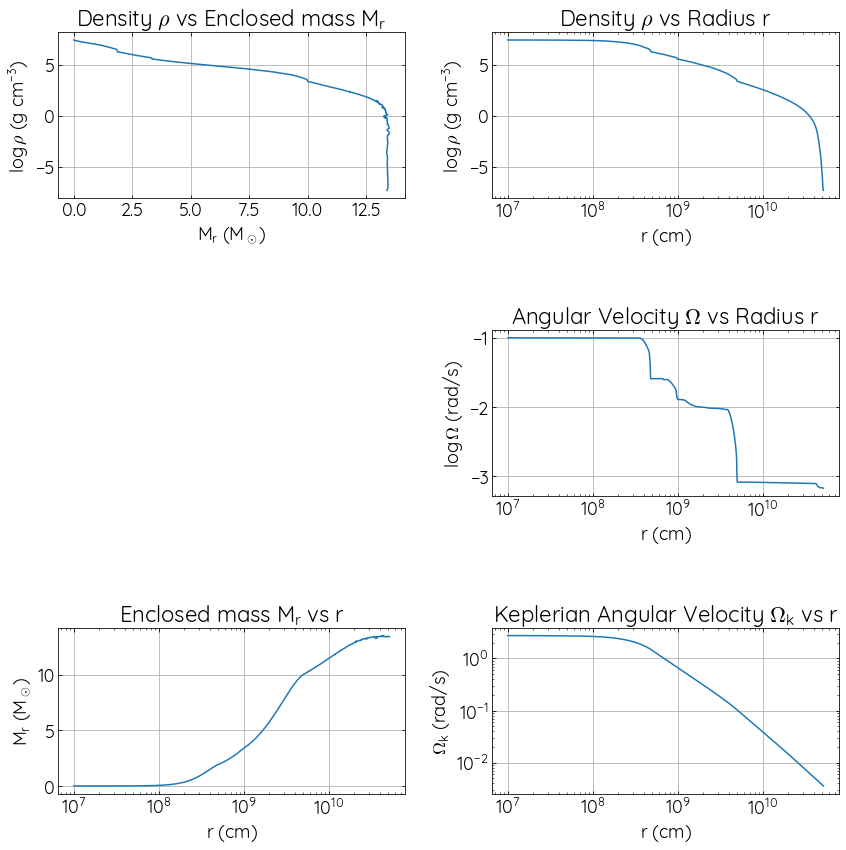

In [123]:
df = pd.read_csv(f'Data/data_{model}.csv')

plt.figure(figsize=(14, 14))
plt.subplots_adjust(hspace=0.8)
plt.subplots_adjust(wspace=0.25)

# Gráfico 1: Densidad vs Masa Encerrada
plt.subplot(3, 2, 1)
plt.plot(df['M_r']/M_sun, np.log10(df['rho_r']))
plt.xlabel(r'$M_r$ ($M_\odot$)')
plt.ylabel(r'$\log \rho$ (g cm$^{-3}$)')
plt.grid(True)
plt.title(r'Density $\rho$ vs Enclosed mass $M_r$ ')

# Gráfico 2: Densidad vs Radio
plt.subplot(3, 2, 2)
plt.semilogx(df['r'], np.log10(df['rho_r']))
plt.xlabel(r'$r$ (cm)')
plt.ylabel(r'$\log \rho$ (g cm$^{-3}$)')
plt.grid(True)
plt.title(r'Density $\rho$ vs Radius $r$')


# Gráfico 4: Velocidad Angular vs Radio
plt.subplot(3, 2, 4)
plt.semilogx(df['r'], np.log10(df['Omega_r']))
plt.xlabel(r'$r$ (cm)')
plt.ylabel(r'$\log \Omega$ (rad/s)')
plt.grid(True)
plt.title(r'Angular Velocity $\Omega$ vs Radius $r$')

# Gráfico 5: Masa Encerrada vs Radio
plt.subplot(3, 2, 5)
plt.semilogx(df['r'], df['M_r']/M_sun)
plt.xlabel(r'$r$ (cm)')
plt.ylabel(r'$M_r$ ($M_\odot$)')
plt.grid(True)
#plt.yticks(ticks_y_Mr)
plt.title(r'Enclosed mass $M_r$ vs $r$')

# Gráfico 6: Velocidad Angular Kepleriana vs Radio
plt.subplot(3, 2, 6)
plt.loglog(df['r'], df['Omega_k'])
plt.xlabel(r'$r$ (cm)')
plt.ylabel(r'$\Omega_k$ (rad/s)')
plt.grid(True)
plt.title(r'Keplerian Angular Velocity $\Omega_k$ vs $r$')



plt.show()


# Definition of $t_{\rm eq}$ and $r_{\rm eq}$

In order to define the above equations, we require first the eccentricity $e(r,\theta)$ function, which is defined as follows:
\begin{equation}
   e(r,\theta)=1-\frac{\Omega_r^2}{\Omega_k^2}\sin^2\theta\ ,
\end{equation}

In this way, the equatorial radius $r_{\rm eq}$ is defined as $r_{\rm eq}(r,\theta)=r(1-e)$ and the equatorial timescale $ t_{\rm eq}(r,\theta)$ is

\begin{equation}
    \label{eq:teq}
    t_{\rm eq}(r,\theta)= \dfrac{1}{\Omega_k}\left(\arccos(-e)+e\sqrt{1-e^2}\right)(1+e)^{-3/2}+t_s(r)  \ ,
\end{equation}

For simplicity, this function is now averaged over theta to eliminate this angular dependence. A wedge integration range of +60º over the equator is considered, assuming that the mass fall-back occurs only within this regime.

    

\begin{align}
    \label{eq:avg_ecc}
   \langle 
{t_{\rm eq}(r,\theta)}_\theta \rangle&=\dfrac{1}{\Delta \Omega} \int_0^{2\pi}\int_{\theta_1}^{\theta_2} t_{\rm eq}(r,\theta)\sin\theta\ d\theta\ d\phi\ , \\ \nonumber
         &= \dfrac{ \int_0^{2\pi}\int_{\theta_1}^{\theta_2} t_{\rm eq}(r,\theta)\sin\theta\ d\theta\ d\phi\ }{\int_0^{2\pi}\int_{\theta_1}^{\theta_2} \sin\theta\ d\theta\ d\phi\ } \ , \\ \nonumber
         &= \dfrac{{2\pi}\int_{\theta_1}^{\theta_2} t_{\rm eq}(r,\theta)\sin\theta\ d\theta\  }{{2\pi}\int_{\theta_1}^{\theta_2} \sin\theta\ d\theta\ \ } \ .
\end{align}

and analogously for $r_{\rm eq}(r,\theta)=r(1-e)$.

In [124]:
df = pd.read_csv(f'Data/data_{model}.csv')
from scipy.integrate import quad

def eccentricity(row, theta):
    return 1 - ((row['Omega_r'] / row['Omega_k']) * np.sin(theta))**2


def avg_teq(row):
    def t_eq_2v(theta):
        e = eccentricity(row, theta)
        parenthesis = (np.arccos(-e) + e * np.sqrt(1 - e**2)) * (1 + e)**(-1.5)
        #t_s_val = R_star / (np.sqrt(gamma * K * row['rho_r']**(2/3)))  
        t_s_val =  1 / row['Omega_k']
        t_eq_val = ( 1 / row['Omega_k']) * parenthesis + t_s_val
        return t_eq_val    
    integrand = lambda theta: t_eq_2v(theta) * np.sin(theta)
    integral, _ = quad(integrand,  theta_initial, theta_final)
    return integral / avg_norm_factor

def avg_req(row):
    def r_fb(theta):
        e = eccentricity(row, theta)
        return row['r'] * (1 - e)
    integrand = lambda theta: r_fb(theta) * np.sin(theta)
    integral, _ = quad(integrand, theta_initial, theta_final)
    avg_req_val = integral / avg_norm_factor
    return avg_req_val

def avg_ecc(row):
    integrand = lambda theta: eccentricity(row, theta) * np.sin(theta)
    integral, _ = quad(integrand, theta_initial, theta_final)
    return integral / avg_norm_factor

def avg_v_phi(row):
    def v_phi(theta):
        e = eccentricity(row, theta)
        return -(row['r'] * row['Omega_k'] * np.sin(theta)) / np.sqrt(1 - e)
    integral, _ = quad(v_phi, theta_initial, theta_final)
    return integral / avg_norm_factor



#df['c_s'] = np.sqrt(gamma * K * df['rho_r']**(2/3))
#df['t_s_polytropic'] = R_star / df['c_s']
#df['t_s_keplerian'] = 1 / df['Omega_k']

df['avg_ecc'] = df.apply(avg_ecc, axis=1)

df['v_phi'] = df.apply(avg_v_phi, axis=1)

df['avg_req'] = df.apply(avg_req, axis=1)

df['r_fb'] = df['r'] * (df['Omega_r'] / df['Omega_k'])**2

df['avg_teq'] = df.apply(avg_teq, axis=1)

# Guardar el DataFrame actualizado
output_data_path = f'Data/data_{model}.csv'
df.to_csv(output_data_path, index=False, float_format='%.8e')
print(f"Archivo guardado en: {output_data_path}")


Archivo guardado en: Data/data_20M_W0.75_D0.2_Z0.1.csv


## Control plots of $t_{\rm eq}(r,\theta)$ and $r_{\rm eq}(r,\theta)$

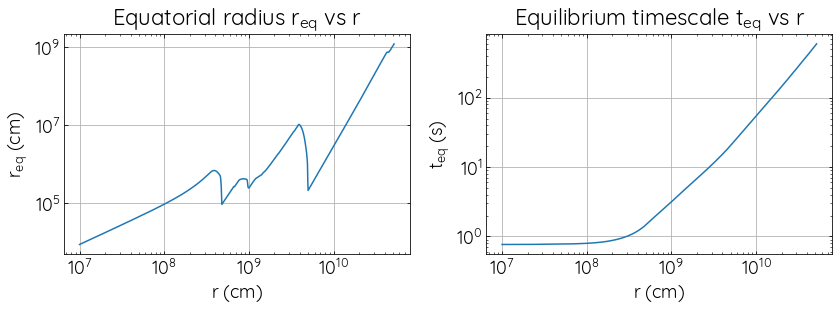

Final radius: 5.18e+10 cm
Final t_eq: 595.09 s


In [125]:
df = pd.read_csv(f'Data/data_{model}.csv')

plt.figure(figsize=(12, 8))
# Plot r_eq vs r
plt.subplot(2, 2, 1)
plt.loglog(df['r'], df['avg_req'])
plt.xlabel(r'$r$ (cm)')
plt.ylabel(r'$r_{\rm eq}$ (cm)')
plt.grid(True)
plt.title(r'Equatorial radius $r_{\rm eq}$ vs r')

# Plot t_eq vs r
plt.subplot(2, 2, 2)
plt.loglog(df['r'], df['avg_teq'])
plt.xlabel(r'$r$ (cm)')
plt.ylabel(r'$t_{\rm eq}$ (s)')
plt.grid(True)
plt.title(r'Equilibrium timescale $t_{\rm eq}$ vs r')

plt.tight_layout()
plt.show()

final_r = df['r'].iloc[-1]  # Last value of r
final_avg_teq = df['avg_teq'].iloc[-1]  # Last value of avg_teq

print(f"Final radius: {final_r:.2e} cm")
print(f"Final t_eq: {final_avg_teq:.2f} s")


## Mass fall-back rate

Mass fall-back rate ($\dot{M}_{\rm fb}$) Black Hole mass ($M_{\rm BH}$): $\dot{M}_{\rm fb}$ describes the rate at which mass falls back onto the disk, and $M_{\rm BH}$ is the mass of the central black hole, accumulated over time. Before calculating the mass fall-back radius, an auxiliary function $H_t$ has to be obtained, defined as
    \begin{equation}
        \label{eq:H_t}
        H_t^{-1} \equiv \left|\dfrac{d}{dr}\ln|t_{\rm eq}|\right|\ ,
    \end{equation} such that,

\begin{equation}
    \dot M_{\rm fb}(t)\equiv \dfrac{d M(r)}{ d t_{\rm eq}}  = \dfrac{d M(r)}{ dr} \dfrac{dr}{ d t_{\rm eq}}=2\pi r^2\rho(r)\dfrac{H_t}{t_{\rm eq}}\displaystyle\int_{\theta_{1}}^{\theta_2}\sin\theta\ d\theta\ ,
\end{equation} 
where on the one hand  $\dfrac{dM(r)}{dr}=2\pi r^2\rho(r)\displaystyle\int_{\theta_{1}}^{\theta_2}\sin\theta\ d\theta$ for the northern hermisphere and on the other hand $\dfrac{dr}{ d t_{\rm eq}}=\dfrac{H_t}{t_{\rm eq}}$ where we have used the chain rule and the fact that $\dfrac{dt_{\rm eq}}{dr} = H_t^{-1}\ t_{\rm eq}$. In this equation, $\displaystyle\int_{\theta_{1}}^{\theta_2}\sin\theta\ d\theta\equiv$ avg_norm_factor.\\

Likewise, the mass of the black hole is obtained by integrating the previous Equation 

\begin{equation}
    \label{eq:M_BH}
    M_{\rm BH} = \int_0^{t_{\rm eq}} \dot{M}_{\rm fb} (t_{\rm eq})\ dt_{\rm eq}\ .
\end{equation}

In the same way, for the northern hemisphere $dJ_r = r\times(dm\cdot\Omega)$ with $dm = 2\pi r^2\rho(r)\displaystyle\int_{\theta_{1}}^{\theta_2}\sin\theta\ d\theta$, so
\begin{equation}
J_r=\int_0^{2\pi}\phi\ d\phi  \int_0^R  r^4\rho(r)\Omega_r\ dr \displaystyle\int_{\theta_{1}}^{\theta_2}\sin\theta\ d\theta=2\pi r^4\rho(r)\ \Omega_r*{\text avg\_norm\_factor}
\end{equation}

Once we have the expressions for the angular momentum and the enclosed mass as a function of radius, the additional spin parameter is defined as
\begin{equation}
    \label{eq:a_*}
    a_*=\dfrac{cJ_r}{GM_r^2}\ ,
\end{equation}





In [126]:
df = pd.read_csv(f'Data/data_{model}.csv')
df.sort_values(by='r', inplace=True)


df['H_t'] = 1 / np.abs(np.gradient(np.log(df['avg_teq']), df['r'], edge_order=2))

df['Mfb_dot'] = 2 *  np.pi * df['r']**2 * df['rho_r'] * avg_norm_factor * (df['H_t'] / df['avg_teq'])

df['M_BH'] =  cumtrapz(df['Mfb_dot'], x=df['avg_teq'], initial=0)

df['integrand'] =  2 *  np.pi * df['r']**4 * df['rho_r'] * df['Omega_r'] * avg_norm_factor
df['J_r'] = cumtrapz(df['integrand'], df['r'], initial=0)
df.drop(columns=['integrand'], inplace=True)

df['a_star'] = (c * df['J_r']) / (G * df['M_r']**2)

# Guardar el DataFrame actualizado
output_data_path = f'Data/data_{model}.csv'
df.to_csv(output_data_path, index=False, float_format='%.8e')
print(f"Archivo guardado en: {output_data_path}")

Archivo guardado en: Data/data_20M_W0.75_D0.2_Z0.1.csv


# Definition of $R_{\rm isco}$

The radius of the ISCO  for a black hole of mass $M_{\rm BH}$ , and $a_*$ is given by:

\begin{equation}
    \label{eq:Risco_fb}
R_{\rm isco}(r) = r {\Omega^2(r)\over\Omega_k^2(r)}\ ,
\end{equation}
and
\begin{equation}
    \label{eq:Risco}
    R_{\text{isco}}(M_{\rm BH},a_*) = \frac{GM_{\rm BH}}{c^2} \left\{ 3 + z_2 - \left[(3-z_1)(3+z_1+2z_2)\right]^{1/2} \right\}\ ,
\end{equation}

with

\begin{equation}
    \label{eq:z1_z2}
    z_1 = 1 + \left(1 - a_*^2\right)^{1/3}\left[ (1+a_*)^{1/3} + (1-a_*)^{1/3} \right], \quad\text{and}\quad z_2 = \left(3 a_*^2 + z_1^2\right)^{1/2}\ .
\end{equation}



These equations are solved numerically to calculate the critical radius $r$ and timescale ($t_{\rm eq}$) inside which all the mass falls directly into the black hole, thereby obtaining the initial mass of the black hole $M_{\rm BH}$ , and $a_*$.


In [127]:
df = pd.read_csv(f'Data/data_{model}.csv')
df.sort_values(by='r', inplace=True)

def R_isco(M_BH, a_star):
    z1 = 1 + (1 - a_star**2)**(1/3) * ((1 + a_star)**(1/3) + (1 - a_star)**(1/3))
    z2 = np.sqrt(3 * a_star**2 + z1**2)
    return (G * M_BH / c**2) * (3 + z2 - np.sqrt((3 - z1) * (3 + z1 + 2 * z2)))

df['R_isco'] = df.apply(lambda row: R_isco(row['M_BH'], row['a_star']), axis=1)
df['Jfb_dot'] = df['Mfb_dot'] * df['r_fb'] * df['v_phi'].abs()


# Guardar el DataFrame actualizado
output_data_path = f'Data/data_{model}.csv'
df.to_csv(output_data_path, index=False, float_format='%.8e')
print(f"Archivo guardado en: {output_data_path}")

Archivo guardado en: Data/data_20M_W0.75_D0.2_Z0.1.csv


/tmp/ipykernel_137187/1055310550.py:5: RuntimeWarning: invalid value encountered in double_scalars
  z1 = 1 + (1 - a_star**2)**(1/3) * ((1 + a_star)**(1/3) + (1 - a_star)**(1/3))


# Control plots of the previously defined functions

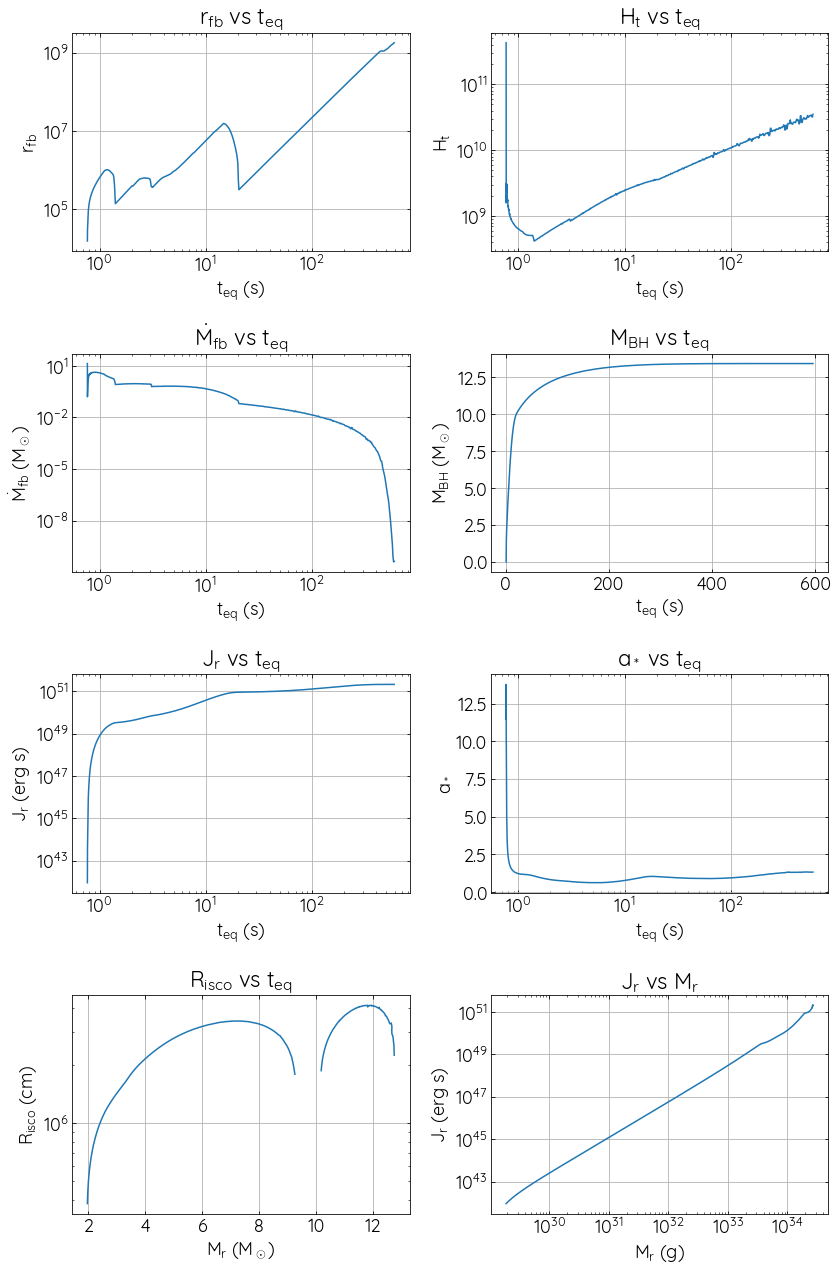

In [128]:
df = pd.read_csv(f'Data/data_{model}.csv')
df = df.iloc[20:].reset_index(drop=True)

# Ensure t_eq is in the correct numeric format
df['avg_teq'] = pd.to_numeric(df['avg_teq'], errors='coerce')

plt.figure(figsize=(12, 18)) 

# Plot r_fb vs t_eq
plt.subplot(4, 2, 1)  # Row 1, Column 1
plt.loglog(df['avg_teq'], df['r_fb'])
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.ylabel(r'$r_{\rm fb}$')
plt.title(r'$r_{\rm fb}$ vs $t_{\rm eq}$')
plt.grid(True)

# Plot H_t vs t_eq
plt.subplot(4, 2, 2)  # Row 1, Column 2
plt.loglog(df['avg_teq'], df['H_t'])
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.ylabel(r'$H_t$')
plt.title(r'$H_t$ vs $t_{\rm eq}$')
plt.grid(True)

# Plot Mfb_dot vs t_eq
plt.subplot(4, 2, 3)  # Row 2, Column 1
plt.loglog(df['avg_teq'], df['Mfb_dot']/M_sun)
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.ylabel(r'$\dot{M}_{\rm fb}$ ($M_\odot$)')
plt.title(r'$\dot{M}_{\rm fb}$ vs $t_{\rm eq}$')
plt.grid(True)

# Plot M_BH vs t_eq
plt.subplot(4, 2, 4)  # Row 2, Column 2
plt.plot(df['avg_teq'], df['M_BH']/M_sun)
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.ylabel(r'$M_{\rm BH}$ ($M_\odot$)')
plt.title(r'$M_{\rm BH}$ vs $t_{\rm eq}$')
plt.grid(True)


# Plot J_r vs t_eq
plt.subplot(4, 2, 5)  # Row 3, Column 1
plt.loglog(df['avg_teq'], df['J_r'])
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.ylabel(r'$J_r$ (erg s)')
plt.title(r'$J_r$ vs $t_{\rm eq}$')
plt.grid(True)

# Plot a_star vs t_eq
plt.subplot(4, 2, 6)  # Row 3, Column 2
plt.semilogx(df['avg_teq'], df['a_star'])
plt.xlabel(r'$t_{\rm eq}$ (s)')
plt.ylabel(r'$a_*$')
plt.title(r'$a_*$ vs $t_{\rm eq}$')
plt.grid(True)

# Plot R_isco vs t_eq
plt.subplot(4, 2, 7)  # Row 4, Column 1
plt.semilogy(df['M_r']/M_sun, df['R_isco'])
plt.ylabel(r'$R_{\rm isco}$ (cm)')
plt.xlabel(r'$M_r$ ($M_\odot$)')
plt.title(r'$R_{\rm isco}$ vs $t_{\rm eq}$')
plt.grid(True)

# Plot J_r vs M_r
plt.subplot(4, 2, 8)  # Row 4, Column 2
plt.loglog(df['M_r'], df['J_r'])
plt.xlabel(r'$M_r$ (g)')
plt.ylabel(r'$J_r$ (erg s)')
plt.title(r'$J_r$ vs $M_r$')
plt.grid(True)
plt.tight_layout()
plt.show()

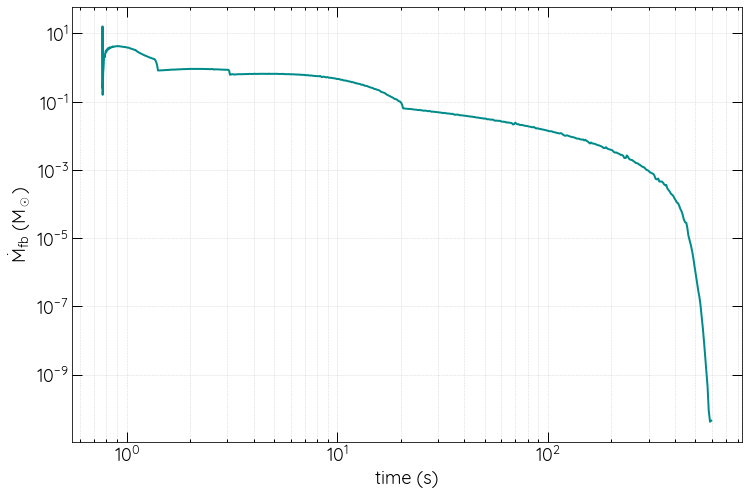

Gráfico guardado en: /fs/phaethon/other0/gibran/accretion/plots/woosley/Mdot_20M_W0.75_D0.2_Z0.1.pdf


In [129]:
df = pd.read_csv(f'Data/data_{model}.csv')
df.sort_values(by='r', inplace=True)

# Definir la interpolación
Jfb_dot_interp = interp1d(df['avg_teq'], df['Jfb_dot'], bounds_error=False, fill_value="extrapolate")

# Gráfica 1: Mass fall-back rate (Mfb_dot) vs t_eq
plt.figure(figsize=(12, 8))
plt.loglog(df['avg_teq'], df['Mfb_dot']/M_sun, color='darkcyan', linewidth=2.0)

# Configurar etiquetas y título
plt.xlabel(r'time (s)', fontsize=18)
plt.ylabel(r'$\dot{M}_{\rm fb}$ ($M_\odot$)', fontsize=18)
#plt.title(r'Mass fall-back rate $\dot{M}_{\rm fb}$ vs $t_{\rm eq}$', fontsize=22)
#plt.legend(fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
#plt.xlim(2e0,1.8e2)
# Configurar ticks
ax = plt.gca()
ax.tick_params(axis='both', which='both', top=True, bottom=True, left=True, right=True, direction='in')
ax.tick_params(which='both', width=1)  # Engrosar ticks
ax.tick_params(which='major', length=10)  # Longitud de ticks principales
ax.tick_params(which='minor', length=3)  # Longitud de ticks secundarios
#ax.xaxis.set_major_locator(LogLocator(base=10, numticks=10))  # Ticks principales en x
#ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))  # Ticks secundarios en x
#ax.yaxis.set_major_locator(LogLocator(base=10, numticks=10))  # Ticks principales en y
#ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))  # Ticks secundarios en y

# Guardar el gráfico
output_file = os.path.join(output_path, f'Mdot_{model}.pdf')
plt.savefig(output_file, format='pdf')
plt.show()



print(f"Gráfico guardado en: {output_file}")

Gráfico guardado en: /fs/phaethon/other0/gibran/accretion/plots/woosley/Jdot_20M_W0.75_D0.2_Z0.1.pdf


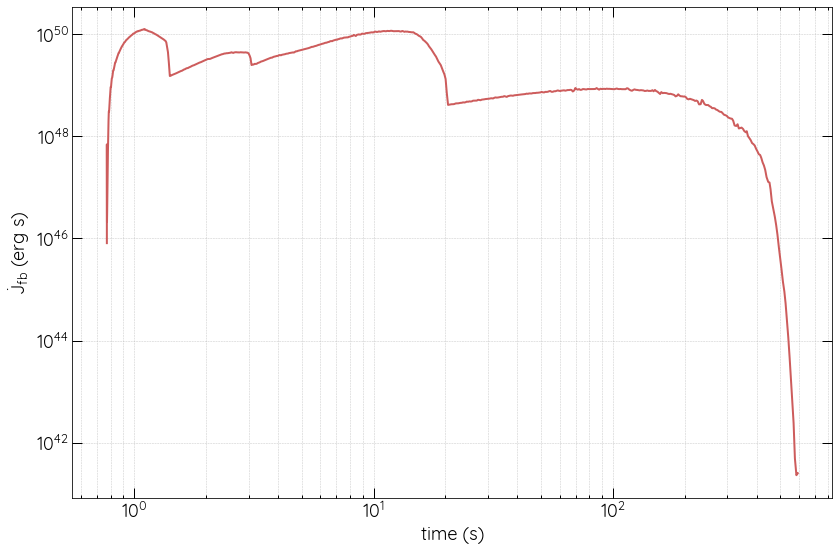

In [130]:
# Gráfica 2: Angular momentum fall-back rate (Jfb_dot) vs t_eq
plt.figure(figsize=(12, 8))
plt.loglog(df['avg_teq'], df['Jfb_dot'], label=r'$\dot{J}_{\rm fb}$', color='indianred',linewidth=2)

# Configurar etiquetas y título
plt.xlabel(r'time (s)', fontsize=18)
plt.ylabel(r'$\dot{J}_{\rm fb}$ (erg s)', fontsize=18)
#plt.title(r'$\dot{J}_{\rm fb}$ vs $t_{\rm eq}$', fontsize=22)
#plt.xlim(2e0,1.8e2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Configurar ticks
ax = plt.gca()
ax.tick_params(axis='both', which='both', top=True, bottom=True, left=True, right=True, direction='in')
ax.tick_params(which='both', width=1)  # Engrosar ticks
ax.tick_params(which='major', length=10)  # Longitud de ticks principales
ax.tick_params(which='minor', length=3)  # Longitud de ticks secundarios
#ax.xaxis.set_major_locator(LogLocator(base=10, numticks=10))  # Ticks principales en x
#ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))  # Ticks secundarios en x
#ax.yaxis.set_major_locator(LogLocator(base=10, numticks=10))  # Ticks principales en y
#ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))  # Ticks secundarios en y

# Ajustar diseño y guardar
plt.tight_layout()
# Guardar el gráfico
output_file = os.path.join(output_path, f'Jdot_{model}.pdf')
plt.savefig(output_file, format='pdf')
print(f"Gráfico guardado en: {output_file}")
plt.show()


# Finding the intersection point between $r_{\rm fb}$ and $R_{\rm isco}$

Intersecciones encontradas (M_r en M_sun):
  Intersección 1: M_r = 1.911 M_sun
  Intersección 2: M_r = 6.577 M_sun
  Intersección 3: M_r = 9.986 M_sun
  Intersección 4: M_r = 11.408 M_sun
  Intersección 5: M_r = 12.677 M_sun
  Intersección 6: M_r = 12.688 M_sun

Valores críticos en la intersección crítica (~ 6.577 M_sun):
  M_BH      = 6.59 M_sun
  avg_teq   = 8.27 s
  r         = 2.38e+09 cm
  a_star    = 0.69


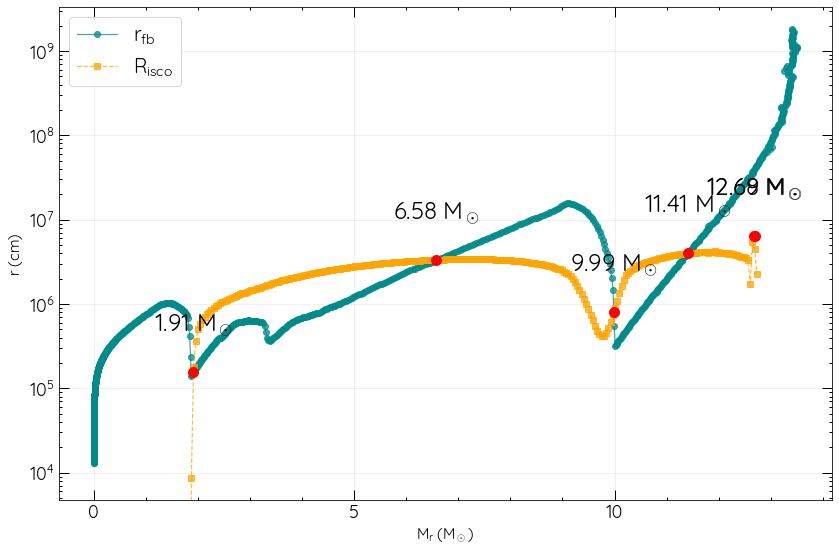

Gráfico guardado en: /fs/phaethon/other0/gibran/accretion/plots/woosley/Rfb_Risco_20M_W0.75_D0.2_Z0.1.pdf


In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
import os
import pandas as pd

# === Constantes físicas ===
M_sun = 1.989e33  # Masa solar (g)

# === Cargar datos ===
df = pd.read_csv(data_path)

# Ordenar por 'r' (opcional)
if 'r' in df.columns:
    df.sort_values(by='r', inplace=True)

# Definir M_r en unidades de masas solares
M_r_solar = df['M_r'] / M_sun

# Filtrar valores válidos
valid_rfb = df['r_fb'].notna()
valid_isco = df['R_isco'].notna()

rfb_r_valid_range = M_r_solar[valid_rfb]
R_isco_valid_range = M_r_solar[valid_isco]

if rfb_r_valid_range.empty or R_isco_valid_range.empty:
    print("No hay valores válidos para r_fb o R_isco.")
    exit()

# Crear funciones de interpolación
rfb_r_interp = interp1d(rfb_r_valid_range, df.loc[valid_rfb, 'r_fb'], kind='cubic')
R_isco_interp = interp1d(R_isco_valid_range, df.loc[valid_isco, 'R_isco'], kind='cubic')

# Definir rango para buscar intersecciones
mint = max(M_r_solar.min(), rfb_r_valid_range.min(), R_isco_valid_range.min())
maxt = min(M_r_solar.max(), rfb_r_valid_range.max(), R_isco_valid_range.max())

# Función de diferencia entre r_fb y R_isco
def intersection_eq(M_r_solar):
    return rfb_r_interp(M_r_solar) - R_isco_interp(M_r_solar)

# Buscar intersecciones
M_r_test = np.linspace(mint, maxt, 1000)
intersections = []

for i in range(1, len(M_r_test)):
    val_prev = intersection_eq(M_r_test[i - 1])
    val_curr = intersection_eq(M_r_test[i])
    if np.sign(val_prev) != np.sign(val_curr):
        res = root_scalar(intersection_eq, bracket=[M_r_test[i - 1], M_r_test[i]])
        if res.converged:
            intersections.append(res.root)

# Imprimir intersecciones (solo para depuración en esta celda)
if intersections:
    print("Intersecciones encontradas (M_r en M_sun):")
    for idx, M_int in enumerate(intersections, start=1):
        print(f"  Intersección {idx}: M_r = {M_int:.3f} M_sun")
# ==============================================================================================================
# SECCIÓN CRÍTICA: SELECCIÓN DE LA INTERSECCIÓN CRÍTICA
# ==============================================================================================================
if len(intersections) >= 1:
    crit_intersection_mass = intersections[1]  # Ajustable manualmente: [1] corresponde al segundo punto.
# ==============================================================================================================

else:
    print("No hay al menos una intersección para seleccionar.")
    crit_intersection_mass = intersections[0] if intersections else None

# Si hay una intersección válida, extraer valores críticos
if crit_intersection_mass is not None:
    # Encontrar el índice más cercano a la intersección crítica
    closest_idx = (np.abs(df['M_r'] / M_sun - crit_intersection_mass)).idxmin()
    
    # Extraer valores críticos
    avg_teq_crit = df.loc[closest_idx, 'avg_teq']
    r_crit = df.loc[closest_idx, 'r']
    M_BH_crit = df.loc[closest_idx, 'M_BH'] / M_sun
    a_star_crit = df.loc[closest_idx, 'a_star']

    # Imprimir valores críticos
    print("\nValores críticos en la intersección crítica (~ {:.3f} M_sun):".format(crit_intersection_mass))
    print(f"  M_BH      = {M_BH_crit:.2f} M_sun")
    print(f"  avg_teq   = {avg_teq_crit:.2f} s")
    print(f"  r         = {r_crit:.2e} cm")
    print(f"  a_star    = {a_star_crit:.2f}")
else:
    print("No se pudo determinar la intersección crítica.")

# Graficar
plt.figure(figsize=(12, 8))

# Graficar r_fb en semilogy
plt.semilogy(M_r_solar, df['r_fb'], 
             label=r"$r_{\rm fb}$", color="darkcyan", 
             marker='o', linestyle='-', linewidth=1.2, alpha=0.75)

# Graficar R_isco (interpolada)
M_r_fine = np.linspace(mint, maxt, 300)
R_isco_vals = R_isco_interp(M_r_fine)
plt.semilogy(M_r_fine, R_isco_vals, 
             label=r"$R_{\rm isco}$", color="orange", 
             marker='s', linestyle='--', linewidth=1.2, alpha=0.75)

# Marcar intersecciones
for M_int in intersections:
    r_int = rfb_r_interp(M_int)
    plt.scatter(M_int, r_int, color='r', s=100, zorder=5)
    plt.text(M_int, r_int * 2.5,  # Multiplicador para mover la etiqueta hacia arriba
             fr'{M_int:.2f} $M_\odot$', 
             fontsize=24, verticalalignment='bottom', horizontalalignment='center')

# Configurar etiquetas y título
plt.xlabel(r'$M_r$ ($M_\odot$)', fontsize=15)
plt.ylabel(r'$r$ (cm)', fontsize=15)
plt.legend(fontsize=20)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

# Configurar ticks
ax = plt.gca()
ax.tick_params(axis='x', which='both', top=True, labeltop=False, bottom=True, labelbottom=True, direction='in')
ax.tick_params(axis='y', which='both', right=True, labelright=False, left=True, labelleft=True, direction='in')
ax.tick_params(which='both', width=1)  # Grosor razonable para ticks
ax.tick_params(which='major', length=10)  # Longitud de ticks principales
ax.tick_params(which='minor', length=3)  # Longitud de ticks secundarios
ax.xaxis.set_major_locator(MultipleLocator(5))  # Ticks principales en x
ax.xaxis.set_minor_locator(MultipleLocator(1))  # Ticks secundarios en x
ax.yaxis.set_major_locator(LogLocator(base=10, numticks=10))  # Ticks principales en y
ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))  # Ticks secundarios en y

# Ajustar diseño y guardar
plt.tight_layout()
output_file = os.path.join(output_path, f'Rfb_Risco_{model}.pdf')
plt.savefig(output_file, format='pdf')
plt.show()

print(f"Gráfico guardado en: {output_file}")

# Finding the intersection point between $J_{\rm fb}$ and $J_{\rm isco}$

In [132]:
def R_S(M_BH):
    return 2 * G * M_BH / c**2

def a_star_BH(M_BH, J_BH):
    return (c * J_BH) / (G * M_BH**2)

def R_isco_BH(M_BH, a_star):
    Z1 = 1 + (1 - a_star**2)**(1/3) * ((1 + a_star)**(1/3) + (1 - a_star)**(1/3))
    Z2 = np.sqrt(3 * a_star**2 + Z1**2)
    return (G * M_BH / c**2) * (3 + Z2 - np.sqrt((3 - Z1) * (3 + Z1 + 2 * Z2)))

def j_isco(M_BH, a_star):
    R_isco_val = R_isco_BH(M_BH, a_star)
    R_s_val = R_S(M_BH)
    
    numerator = (R_isco_val**2 - a_star * R_s_val * np.sqrt(R_isco_val * R_s_val / 2) + a_star**2 * R_s_val**2 / 4)
    denominator = R_isco_val * np.sqrt(R_isco_val**2 - 3 * R_isco_val * R_s_val / 2 + a_star * R_s_val * np.sqrt(R_isco_val * R_s_val / 2))
    
    return np.sqrt(G * M_BH * R_isco_val) * numerator / denominator


def j_kerr(M_BH):
    return j_isco(M_BH, a_star=1)

def j_sch(M_BH):
    return np.sqrt(12) * (G * M_BH / c)
    


🔍 Intersección encontrada en M_r = 12.12 M_sun, j = 1.11e+17 cm²/s


/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


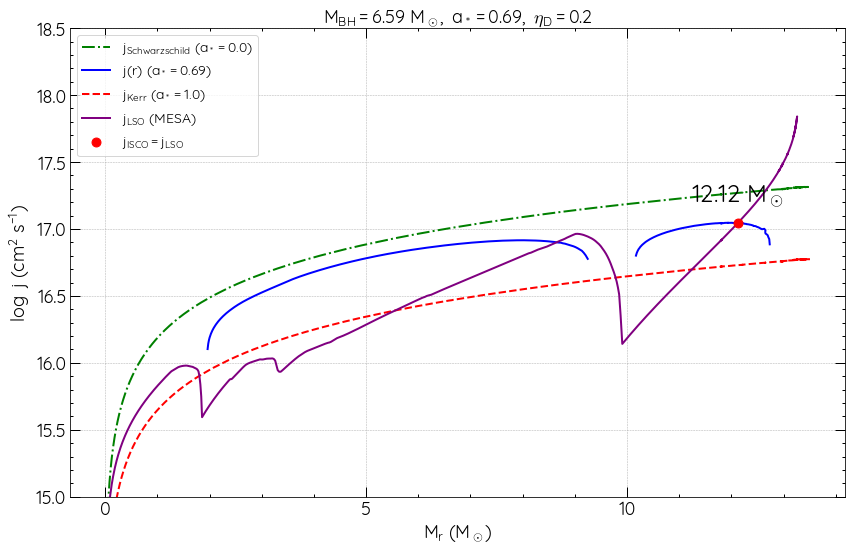

✅ Gráfica guardada en: /fs/phaethon/other0/gibran/accretion/plots/woosley/J_Mr_20M_W0.75_D0.2_Z0.1.pdf


In [133]:
# === Cargar el DataFrame con j_LSO ya almacenado ===
data_path = f"Data/data_{model}.csv"
df = pd.read_csv(data_path)

# === Asegurar valores críticos ===
M_BH_crit_cgs = M_BH_crit * M_sun  # Convertir a gramos
a_star_crit = a_star_crit  # Ya está en la unidad correcta

# === Calcular j para todo el perfil ===
df['j_isco'] = j_isco(df['M_BH'], df['a_star'])
df['j_kerr'] = G * df['M_BH'] / c
df['j_sch'] = j_sch(df['M_BH'])

# === Calcular j_ISCO crítico con valores críticos ===
j_isco_crit = j_isco(M_BH_crit_cgs, a_star_crit)

# === Encontrar la intersección entre j_isco y j_LSO en el DataFrame ===
df['diff_j'] = np.abs(np.log10(df['j_isco']) - np.log10(df['j_LSO']))  # Diferencia en log10
closest_index = df['diff_j'].idxmin()  # Índice de la menor diferencia

# Extraer valores en la intersección
intersection_Mr = df.loc[closest_index, 'M_r'] / M_sun
intersection_j = np.log10(df.loc[closest_index, 'j_isco'])

print(f"🔍 Intersección encontrada en M_r = {intersection_Mr:.2f} M_sun, j = {10 ** intersection_j:.2e} cm²/s")

# === Graficar ===
plt.figure(figsize=(12, 8))

# 1️⃣ Graficar cada j en función de M_r
plt.plot(df['M_r'] / M_sun, np.log10(df['j_sch']), label=r"$j_{\rm Schwarzschild}\ (a_*=0.0)$", color='green', linestyle='-.', linewidth=2)
plt.plot(df['M_r'] / M_sun, np.log10(df['j_isco']), label=fr"$j(r)\ (a_*={a_star_crit:.2f})$", color='blue', linestyle='-', linewidth=2)
plt.plot(df['M_r'] / M_sun, np.log10(df['j_kerr']), label=r"$j_{\rm Kerr}\ (a_*=1.0)$", color='red', linestyle='--', linewidth=2)
plt.plot(df['M_r'] / M_sun, np.log10(df['j_LSO']), label=r"$j_{\rm LSO}$ (MESA)", color='purple', linestyle='-', linewidth=2)
#plt.scatter([M_r_crit_actual], [np.log10(j_isco_crit)], color='black', s=100, zorder=5, label=r"$r_{\rm ISCO} = r_{\rm fb}$")




# 2️⃣ Marcar la intersección de j_isco con j_LSO
plt.scatter([intersection_Mr], [intersection_j], color='red', s=80, zorder=5, label=r"$j_{\rm ISCO} = j_{\rm LSO}$")
plt.text(intersection_Mr, intersection_j + 0.1, f"{intersection_Mr:.2f} $M_\odot$", 
         fontsize=24, ha='center', va='bottom', )

# 3️⃣ Configuración de la gráfica
plt.xlabel(r'$M_r$ ($M_\odot$)', fontsize=18)
plt.ylabel(r'$\log \ j$ ($\rm cm^2\ s^{-1}$)', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True, which='major', linestyle='--', linewidth=0.5)
plt.title(fr'$M_{{\rm BH}}={M_BH_crit:.2f} \ M_\odot,\ a_*={a_star_crit:.2f}, \ \eta_D={eta_d}$', fontsize=18)
plt.tight_layout()
plt.ylim(15, 18.5)


# Obtener el eje actual (debe estar antes de configurar ticks)
ax = plt.gca()

# Configurar ticks en todos los ejes
ax.tick_params(axis='x', which='both', top=True, labeltop=False, bottom=True, labelbottom=True, direction='in')
ax.tick_params(axis='y', which='both', right=True, labelright=False, left=True, labelleft=True, direction='in')

# Engrosar y ajustar el tamaño de los ticks
ax.tick_params(which='both', width=1)  # Grosor razonable para ticks principales y secundarios
ax.tick_params(which='both', length=10)  # Longitud de los ticks principales
ax.tick_params(which='minor', length=3)  # Longitud de los ticks secundarios

ax.xaxis.set_major_locator(MultipleLocator(5))  # Ticks principales en x cada 10 M_sun
ax.xaxis.set_minor_locator(MultipleLocator(1))   # Ticks secundarios en x cada 2 M_sun
ax.yaxis.set_major_locator(MultipleLocator(0.5))  # Ticks principales en x cada 10 M_sun
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

# Guardar el gráfico
output_file = os.path.join(output_path, f'J_Mr_{model}.pdf')
plt.savefig(output_file, format='pdf')
plt.show()


# Mostrar la gráfica
plt.show()

print(f"✅ Gráfica guardada en: {output_file}")


In [134]:
# Initial conditions basadas en valores críticos
alpha = 0.1  # Viscosity parameter
t0 = avg_teq_crit  # Intersection time point between r_fb and R_isco (s)
tf = df['avg_teq'].iloc[-1] #Last value of avg_teq
a_star0 = a_star_crit  # Intersection initial spin
M_BH0 = M_BH_crit * M_sun  # Intersection initial black hole mass (g)
J_BH0 = (a_star0 * G * M_BH0**2) / c  # Initial black hole angular momentum calculated from a_star0 (erg s)
M_d0 = 1e-10 * M_BH0  # Initial disk mass (g)
J_d0 = 1e-10 * J_BH0  # Initial disk angular momentum (erg s)

# Imprimir condiciones iniciales para verificación
print("Condiciones iniciales basadas en la intersección")
print(f"  t0         = {t0:.2f} s")
print(f"  tf         = {tf:.2f} s")
print(f"  a_star0    = {a_star0:.2f}")
print(f"  M_BH0      = {M_BH0:.2e} g")
print(f"  M_BH0      = {M_BH0 / M_sun:.2f} M_sun")  # Convertir a M_sun para impresión
print(f"  J_BH0      = {J_BH0:.2e} erg s")
print(f"  M_d0       = {M_d0:.2e} g")
print(f"  M_d0      = {M_d0 / M_sun:.2e} M_sun")  # Convertir a M_sun para impresión
print(f"  J_d0       = {J_d0:.2e} erg s")


# Load DataFrame and interpolation functions
df = pd.read_csv(f'Data/data_{model}.csv')
df.sort_values(by='avg_teq', inplace=True)
Mfb_dot_interp = interp1d(df['avg_teq'], df['Mfb_dot'], bounds_error=False, fill_value="extrapolate")
Jfb_dot_interp = interp1d(df['avg_teq'], df['Jfb_dot'], bounds_error=False, fill_value="extrapolate")

Condiciones iniciales basadas en la intersección
  t0         = 8.27 s
  tf         = 595.09 s
  a_star0    = 0.69
  M_BH0      = 1.31e+34 g
  M_BH0      = 6.59 M_sun
  J_BH0      = 2.64e+50 erg s
  M_d0       = 1.31e+24 g
  M_d0      = 6.59e-10 M_sun
  J_d0       = 2.64e+40 erg s


In [135]:
# Functions
def a_star_BH(J_BH, M_BH):
    return (c * J_BH) / (G * M_BH**2)

def R_S(M_BH):
    return 2 * G * M_BH / c**2

def R_isco_BH(M_BH, J_BH):
    a_star_val = a_star_BH(J_BH=J_BH, M_BH=M_BH)  # Use the spin parameter from a_star_BH function
    z1 = 1 + (1 - a_star_val**2)**(1/3) * ((1 + a_star_val)**(1/3) + (1 - a_star_val)**(1/3))
    z2 = np.sqrt(3 * a_star_val**2 + z1**2)
    return (G * M_BH / c**2) * (3 + z2 - np.sqrt((3 - z1) * (3 + z1 + 2 * z2)))

def j_isco(M_BH, J_BH):
    a_star_val = a_star_BH(M_BH=M_BH, J_BH=J_BH)
    R_isco_val = R_isco_BH(M_BH=M_BH, J_BH=J_BH)
    R_s_val = R_S(M_BH=M_BH)
    numerator = (R_isco_val**2 - a_star_val * R_s_val * np.sqrt(R_isco_val * R_s_val / 2) + a_star_val**2 * R_s_val**2 / 4)
    denominator = R_isco_val * np.sqrt(R_isco_val**2 - 3 * R_isco_val * R_s_val / 2 + a_star_val * R_s_val * np.sqrt(R_isco_val * R_s_val / 2))
     
    return np.sqrt(G * M_BH * R_isco_val) * numerator / denominator

def r_d(J_d, M_d, M_BH):
    return ((J_d / M_d)**2) / (G * M_BH)

def t_acc(M_BH, J_d, M_d):
    r_d_val =  r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
    Omega_k_BH = np.sqrt(G * M_BH / r_d_val**3)
    return 2 / (alpha * Omega_k_BH)

def dot_m_acc(M_d, J_d, M_BH): #Adimensional dot_m_acc (dotmacc/(M_sun/s))
    r_d_val = r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
    t_acc_val = t_acc(J_d=J_d, M_d=M_d, M_BH=M_BH)
    dot_M_acc = M_d / t_acc_val  
    dot_m_acc_val = dot_M_acc / M_sun 
    return dot_m_acc_val


def r_t(M_d, J_d, M_BH):
    R_s_val = R_S(M_BH=M_BH)
    r_d_val = r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
    dot_m_acc_val = dot_m_acc(J_d=J_d, M_d=M_d, M_BH=M_BH)
    return R_s_val * (10 ** 2.5 * dot_m_acc_val * (r_d_val / R_s_val) ** -s) ** (1 / (1 - s))

# Conditional function for dot_M_BH based on accretion regimes
def dot_m_BH(M_d, J_d, M_BH, J_BH):
    R_s_val = R_S(M_BH=M_BH)
    r_d_val = r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
    R_isco_val = R_isco_BH(M_BH=M_BH, J_BH=J_BH)
    dot_m_acc_val = dot_m_acc(J_d=J_d, M_d=M_d, M_BH=M_BH)
    
    log_dot_macc = np.log10(dot_m_acc_val)
    log_rd_Rs = np.log10(r_d_val / R_s_val)
    log_Risco_Rs = np.log10(R_isco_val / R_s_val)
    log_rd_Risco = np.log10(r_d_val / R_isco_val)
    
    #return dot_m_acc_val

    # NDAF
    if log_rd_Rs - 2.5 <= log_dot_macc:
        #print("NDAF regime")
        return dot_m_acc_val
    # NADAF
    elif log_Risco_Rs + s * log_rd_Risco - 2.5 <= log_dot_macc < log_rd_Rs - 2.5:
        #print("NADAF regime")
        return np.power(10, (1 / (1 - s)) * (log_dot_macc - s * log_rd_Rs + 2.5 * s))
    # ADAF
    elif log_dot_macc < log_Risco_Rs + s * log_rd_Risco - 2.5:
        #print("ADAF regime")
        return np.power(10, log_dot_macc - s * log_rd_Risco)
    



# Function for dot_J_acc
def dot_J_acc(M_BH, J_BH, M_d, J_d):
    R_s_val = R_S(M_BH=M_BH)
    R_isco_val = R_isco_BH(M_BH=M_BH, J_BH=J_BH)
    j_isco_val = j_isco(M_BH=M_BH, J_BH=J_BH)
    r_d_val = r_d(J_d=J_d, M_d=M_d, M_BH=M_BH)
    jr_d_val = np.sqrt(G * M_BH * r_d_val)
    dot_M_acc_val = dot_m_acc(J_d=J_d, M_d=M_d, M_BH=M_BH) * M_sun
    dot_M_BH_val = dot_m_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d) * M_sun
    r_t_val = r_t(M_BH=M_BH, J_d=J_d, M_d=M_d)
         
    return j_isco_val * dot_M_BH_val + (2 * s / (2 * s + 1)) * jr_d_val * dot_M_acc_val * (1 - (r_t_val / r_d_val)**((2 * s + 1) / 2))


def dot_J_BH(M_d, J_d, M_BH, J_BH):
    j_isco_val = j_isco(M_BH=M_BH, J_BH=J_BH)
    dot_M_BH_val = dot_m_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d) * M_sun
    return dot_M_BH_val * j_isco_val


# ODE System
def ODE_system(t, y):
    M_d, J_d, M_BH, J_BH = y
    R_d_val = r_d(M_BH=M_BH, J_d=J_d, M_d=M_d)
    J_isco_val = j_isco(M_BH=M_BH, J_BH=J_BH)

    # Definitions on rates in cgs
    Dot_Mfb = Mfb_dot_interp(t)
    Dot_Jfb = Jfb_dot_interp(t)
    Dot_Macc = dot_m_acc(J_d=J_d, M_d=M_d, M_BH=M_BH) * M_sun
    Dot_Jacc = dot_J_acc(M_BH=M_BH, J_BH=J_BH, M_d=M_d, J_d=J_d)
    Dot_MBH = dot_m_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d) * M_sun
    Dot_JBH = dot_J_BH(M_BH=M_BH, J_BH=J_BH, J_d=J_d, M_d=M_d)

    #Actual ODE
    Dot_M_d = Dot_Mfb - Dot_Macc
    Dot_J_d = Dot_Jfb - Dot_Jacc
    Dot_M_BH = Dot_MBH
    Dot_J_BH = Dot_JBH

    return [Dot_M_d, Dot_J_d, Dot_M_BH, Dot_J_BH]

def eta_j(a_star):
    return 0.07 * (a_star / (1 + np.sqrt(1 - a_star**2)))**5

def L_jet(dot_M_BH, a_star):
    eta = eta_j(a_star)
    return eta * dot_M_BH * c**2

In [136]:
s = 0.5  # Model parameter

tf = df['avg_teq'].iloc[-1] #Last value of avg_teq
t_span = (t0, tf)#The solver will attempt to compute the solution to the 
#System of ODEs starting from t = t0 and progressing up to t =tf.
y0 = [M_d0, J_d0, M_BH0, J_BH0] 

#sol = solve_ivp(ODE_system, t_span, y0, dense_output=True)
sol = solve_ivp(ODE_system, t_span, y0, dense_output=True, rtol=1e-6, atol=1e-9)


times = sol.t
M_d = sol.y[0]
J_d = sol.y[1]
M_BH = sol.y[2]
J_BH = sol.y[3]
a_star = (c * J_BH) / (G * M_BH**2) 


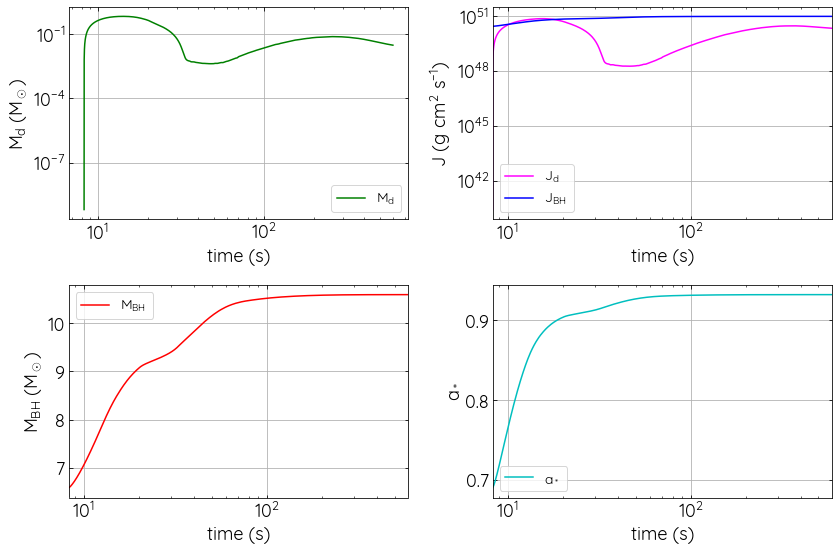

✅ Gráfica guardada en: /fs/phaethon/other0/gibran/accretion/plots/woosley/MBH_a(t)_S0.5_20M_W0.75_D0.2_Z0.1.pdf


In [137]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.loglog(times, M_d/M_sun, label=r'$M_d$ ', color="g")
plt.xlabel('time (s)')
plt.ylabel(r'${M}_{\rm d}$ ($M_\odot$)')
#plt.xlim(t0-11,tf)
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.loglog(times, J_d, label=r'$J_d$ ', color = "magenta")
plt.loglog(times, J_BH, label=r'$J_{\rm BH}$ ', color = "blue")
plt.xlabel('time (s)')
plt.ylabel(r'$J\ (\rm{g\ cm}^2\ \rm{s}^{-1})$')
plt.xlim(t0,tf)
#plt.ylim(1e51,5e52)
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
plt.semilogx(times, M_BH/M_sun, label=r'$M_{\rm BH}$ ', color="r")
plt.xlabel('time (s)')
plt.ylabel(r'${M}_{\rm BH}$ ($M_\odot$)')
plt.grid(True)
plt.xlim(t0,tf)
#plt.ylim(5,10)
plt.legend()

plt.subplot(2, 2, 4)
plt.semilogx(times,(a_star), label=r'$a_*$ ',color="c")
plt.xlabel('time (s)')
plt.ylabel(r'$a_*$')
#plt.ylim(0.5,1)
plt.xlim(t0,tf)
plt.grid(True)
plt.legend()
plt.tight_layout()


# Guardar el gráfico
output_file = os.path.join(output_path, f'MBH_a(t)_S{s}_{model}.pdf')
#plt.savefig(output_file, format='pdf')
plt.show()


# Mostrar la gráfica
plt.show()

print(f"✅ Gráfica guardada en: {output_file}")

In [138]:
# Testings
t_initial = t0
y0 = [M_d0, J_d0, M_BH0, J_BH0]
initial_dot_M_d = Mfb_dot_interp(t_initial) - dot_m_acc(M_d0, J_d0, M_BH0) * M_sun
initial_dot_J_d = Jfb_dot_interp(t_initial) - dot_J_acc(M_BH0, J_BH0, M_d0, J_d0)

# Imprimir valores iniciales con M_BH0 y M_d0 en M_sun
print(f"(M_BH0, J_BH0, M_d0, J_d0) = {(M_BH0 / M_sun):.2f} M_sun, {J_BH0:.2e} erg s, {(M_d0 / M_sun):.2e} M_sun, {J_d0:.2e} erg s")
print(f"Initial time: {t_initial:.2f} s")
print(f"Initial a_star_M_BH: {a_star_BH(J_BH0, M_BH0):.2f}\n")
print(f"Initial R_S: {R_S(M_BH0):.2e} cm")
print(f"Initial Risco: {R_isco_BH(M_BH0, J_BH0):.2e} cm")
print(f"Initial r_d: {r_d(J_d0, M_d0, M_BH0):.2e} cm")
print(f"Initial r_t: {r_t(M_d0, J_d0, M_BH0):.2e} cm \n")
print(f"Initial t_acc: {t_acc(M_BH0, J_d0, M_d0):.2e} s")
print(f"Initial j_isco: {j_isco(M_BH0, J_BH0):.2e} \n")
print(f"Initial dot_M_fb: {Mfb_dot_interp(t_initial):.2e} g/s")
print(f"Initial dot_m_acc: {dot_m_acc(M_d0, J_d0, M_BH0):.2e} g/s")
print(f"Initial dot_M_d: {initial_dot_M_d:.2e} g/s \n")
print(f"Initial dot_J_fb: {Jfb_dot_interp(t_initial):.2e} erg s")
print(f"Initial dot_J_acc: {dot_J_acc(M_BH0, J_BH0, M_d0, J_d0):.2e} erg s")
print(f"Initial dot_J_d: {initial_dot_J_d:.2e} erg s \n")
print(f"Initial dot_M_BH: {dot_m_BH(M_d0, J_d0, M_BH0, J_BH0):.2e} g/s")
print(f"Initial dot_J_BH: {dot_J_BH(M_d0, J_d0, M_BH0, J_BH0):.2e} erg s")

(M_BH0, J_BH0, M_d0, J_d0) = 6.59 M_sun, 2.64e+50 erg s, 6.59e-10 M_sun, 2.64e+40 erg s
Initial time: 8.27 s
Initial a_star_M_BH: 0.69

Initial R_S: 1.95e+06 cm
Initial Risco: 3.35e+06 cm
Initial r_d: 4.63e+05 cm
Initial r_t: 7.79e+00 cm 

Initial t_acc: 2.13e-04 s
Initial j_isco: 7.60e+16 

Initial dot_M_fb: 1.13e+33 g/s
Initial dot_m_acc: 3.09e-06 g/s
Initial dot_M_d: 1.13e+33 g/s 

Initial dot_J_fb: 9.61e+49 erg s
Initial dot_J_acc: 1.32e+45 erg s
Initial dot_J_d: 9.61e+49 erg s 

Initial dot_M_BH: 8.30e-06 g/s
Initial dot_J_BH: 1.25e+45 erg s


In [139]:
Dot_M_BH = np.gradient(M_BH, times) 

a_star = (c * J_BH) / (G * M_BH**2)
eta_vals = eta_j(a_star)
L_jet_vals = L_jet(Dot_M_BH, a_star)

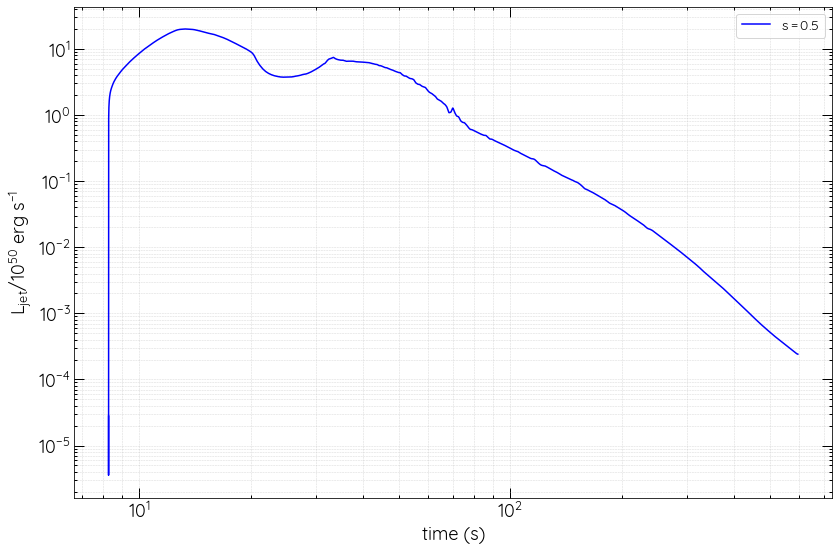

✅ Gráfica guardada en: /fs/phaethon/other0/gibran/accretion/plots/woosley/Lj_S0.5_20M_W0.75_D0.2_Z0.1.pdf


In [140]:
# Crear la figura
plt.figure(figsize=(12, 8))

# Graficar
plt.loglog(times, L_jet_vals / 1e50, color="b", label=f'$s={s}$')

# Configurar etiquetas y título con tamaño de fuente adecuado
plt.ylabel(r"$L_{\rm jet}/10^{50}$ erg s$^{-1}$", fontsize=18)
plt.xlabel('time (s)', fontsize=18)
plt.legend()
#plt.xlim(t0,tf)
# Añadir cuadrícula
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Configurar ticks
ax = plt.gca()
ax.tick_params(axis='both', which='both', top=True, bottom=True, left=True, right=True, direction='in')
ax.tick_params(which='both', width=1)  # Engrosar ticks
ax.tick_params(which='major', length=10)  # Longitud de ticks principales
ax.tick_params(which='minor', length=3)  # Longitud de ticks secundarios
ax.xaxis.set_major_locator(LogLocator(base=10, numticks=10))  # Ticks principales en x
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))  # Ticks secundarios en x
ax.yaxis.set_major_locator(LogLocator(base=10, numticks=10))  # Ticks principales en y
ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))  # Ticks secundarios en y

# Ajustar diseño y guardar
plt.tight_layout()
# Guardar el gráfico
output_file = os.path.join(output_path, f'Lj_S{s}_{model}.pdf')
plt.savefig(output_file, format='pdf')
plt.show()


# Mostrar la gráfica
plt.show()

print(f"✅ Gráfica guardada en: {output_file}")


In [141]:
results = {}
#s_values = [0, 0.25, 0.5, 0.75, 0.99]
s_values = [0.25,0.5,0.75]


for s in s_values:
    t_span = (t0, tf)
    t_eval = np.linspace(t0,tf,1000)
    y0 = [M_d0, J_d0, M_BH0, J_BH0] 

    sol = solve_ivp(ODE_system, t_span, y0, dense_output=True, t_eval=t_eval, rtol=1e-6, atol=1e-9)


    times = sol.t
    M_d = sol.y[0]
    J_d = sol.y[1]
    M_BH = sol.y[2]
    J_BH = sol.y[3]

    Dot_M_BH = np.gradient(M_BH, times) 
    a_star = (c * J_BH) / (G * M_BH**2)
    L_jet_vals_s = L_jet(Dot_M_BH, a_star)

    results[str(s)] = {
        'times': times,
        'L_jet': L_jet_vals_s,
        'M_d': M_d,
        'J_d': J_d,
        'J_BH': J_BH,
        'M_BH': M_BH,
        'a_star': a_star
    }  

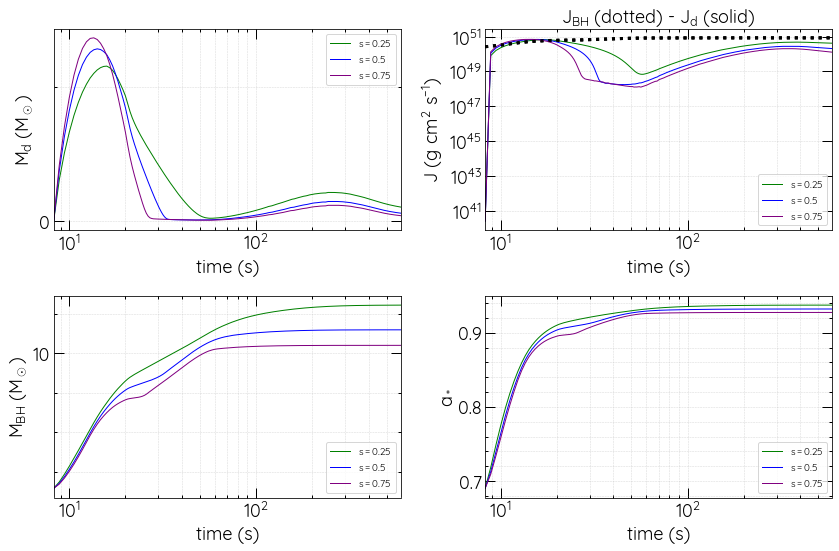

✅ Gráfica guardada en: /fs/phaethon/other0/gibran/accretion/plots/woosley/MBH_a_20M_W0.75_D0.2_Z0.1.pdf


In [142]:
# Configurar figura
plt.figure(figsize=(12, 8))
# Definir estilos de línea para diferenciar cada valor de 's'
line_styles = ['-', '-', '-', '-']

# Asignar colores a cada subgráfico
colors = [
    'green', 'blue', 'purple', 'darkorange', 'red',  'royalblue'
]

# Iterar sobre cada simulación guardada en el diccionario 'results'
for i, (s, data) in enumerate(results.items()):
    style = line_styles[i % len(line_styles)]
    times = data['times']
    M_d = data['M_d']
    J_d = data['J_d']
    M_BH = data['M_BH']
    a_star = data['a_star']

    # Panel 1: Masa del disco
    plt.subplot(2, 2, 1)
    plt.semilogx(times, M_d / M_sun, linestyle=style, label=f'$s={s}$', color=colors[i], linewidth=1)  
    plt.xlabel('time (s)', fontsize=18)
    plt.ylabel(r'${M}_{\rm d}$ ($M_\odot$)', fontsize=18)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.xlim(t0, tf)
    plt.legend(loc='best', fontsize=10, frameon=True, handlelength=2)

    # Configurar ticks para Panel 1
    ax = plt.gca()
    ax.tick_params(axis='both', which='both', top=True, bottom=True, left=True, right=True, direction='in')
    ax.tick_params(which='both', width=1)
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=3)
    ax.xaxis.set_major_locator(LogLocator(base=10, numticks=10))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
    ax.yaxis.set_major_locator(MultipleLocator(2))  # Ajustar según rango de M_d/M_sun
    ax.yaxis.set_minor_locator(MultipleLocator(0.5))

    # Panel 2: Momento angular
    plt.subplot(2, 2, 2)
    plt.loglog(times, J_d, linestyle=style, linewidth=1, label=f'$s={s}$', color=colors[i]) 
    plt.loglog(times, J_BH, linestyle=":", color="black", linewidth=3, alpha=0.9) 
    #plt.ylim(1e51, 5e52)
    plt.xlim(t0, tf)
    plt.xlabel('time (s)', fontsize=18)
    plt.ylabel(r'$J\ (\rm{g\ cm}^2\ \rm{s}^{-1})$', fontsize=18)
    plt.title(r"$J_{\rm BH}$ (dotted) - $J_{\rm d}$ (solid)", fontsize=18)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.legend(loc='lower right', fontsize=10, frameon=True, handlelength=2)

    # Configurar ticks para Panel 2
    ax = plt.gca()
    ax.tick_params(axis='both', which='both', top=True, bottom=True, left=True, right=True, direction='in')
    ax.tick_params(which='both', width=1)
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=3)
    ax.xaxis.set_major_locator(LogLocator(base=10, numticks=10))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=10))
    ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))

    # Panel 3: Masa del agujero negro
    plt.subplot(2, 2, 3)
    plt.semilogx(times, M_BH / M_sun, linestyle=style, label=f'$s={s}$', color=colors[i], linewidth=1) 
    plt.xlabel('time (s)', fontsize=18)
    plt.xlim(t0, tf)
    plt.ylabel(r'${M}_{\rm BH}$ ($M_\odot$)', fontsize=18)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.legend(loc='lower right', fontsize=10, frameon=True, handlelength=2)

    # Configurar ticks para Panel 3
    ax = plt.gca()
    ax.tick_params(axis='both', which='both', top=True, bottom=True, left=True, right=True, direction='in')
    ax.tick_params(which='both', width=1)
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=3)
    ax.xaxis.set_major_locator(LogLocator(base=10, numticks=10))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
    ax.yaxis.set_major_locator(MultipleLocator(5))  # Ajustar según rango de M_BH/M_sun
    ax.yaxis.set_minor_locator(MultipleLocator(1))

    # Panel 4: Parámetro de spin
    plt.subplot(2, 2, 4)
    plt.semilogx(times, a_star, linestyle=style, label=f'$s={s}$', color=colors[i], linewidth=1)  # Púrpura
    plt.xlabel('time (s)', fontsize=18)
    plt.ylabel(r'$a_*$', fontsize=18)
    plt.xlim(t0, tf)
    # plt.ylim(0.5, 1)  # Descomentar si necesitas límites
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.legend(loc='lower right', fontsize=10, frameon=True, handlelength=2)

    # Configurar ticks para Panel 4
    ax = plt.gca()
    ax.tick_params(axis='both', which='both', top=True, bottom=True, left=True, right=True, direction='in')
    ax.tick_params(which='both', width=1)
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=3)
    ax.xaxis.set_major_locator(LogLocator(base=10, numticks=10))
    ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
    ax.yaxis.set_major_locator(MultipleLocator(0.1))  # Ajustar según rango de a_star
    ax.yaxis.set_minor_locator(MultipleLocator(0.02))


# Ajustar diseño y guardar
plt.tight_layout()
# Guardar el gráfico
output_file = os.path.join(output_path, f'MBH_a_{model}.pdf')
plt.savefig(output_file, format='pdf')
plt.show()


# Mostrar la gráfica
plt.show()

print(f"✅ Gráfica guardada en: {output_file}")

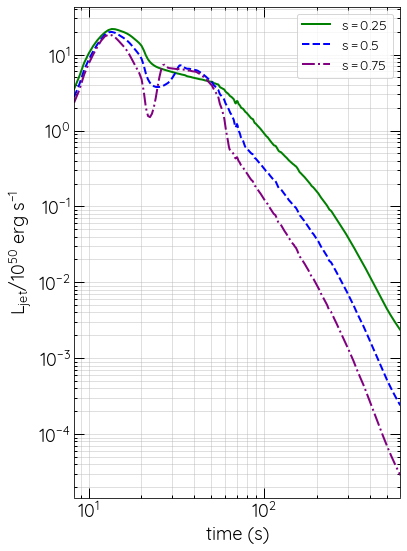

✅ Gráfica guardada en: /fs/phaethon/other0/gibran/accretion/plots/woosley/Lj_20M_W0.75_D0.2_Z0.1.pdf


In [143]:
plt.figure(figsize=(6, 8))
colors = [
    'green', 'blue', 'purple', 'darkorange', 'red',  'royalblue'
]
line_styles = ['-', '--', '-.', ':']

for i, (s, data) in enumerate(results.items()):
    style = line_styles[i % len(line_styles)]
    times = data['times'] 
    L_jet_vals_s = data['L_jet']  

    plt.loglog(times, L_jet_vals_s/1e50, linestyle=style, label=f'$s={s}$', markersize=8, linewidth=2,color=colors[i])

plt.ylabel(r"$L_{\rm jet}/10^{50}$ erg s$^{-1}$",fontsize=18)
plt.xlabel(r'time (s)',fontsize=18)
#plt.ylim(1e-5, 3e1)
plt.xlim(t0, tf)
plt.grid(True, which="both", alpha=0.5)
plt.legend(loc='best',frameon=True, handlelength=2)

# Configurar ticks
ax = plt.gca()
ax.tick_params(axis='both', which='both', top=True, bottom=True, left=True, right=True, direction='in')
ax.tick_params(which='both', width=1)  # Engrosar ticks
ax.tick_params(which='major', length=10)  # Longitud de ticks principales
ax.tick_params(which='minor', length=3)  # Longitud de ticks secundarios
ax.xaxis.set_major_locator(LogLocator(base=10, numticks=10))  # Ticks principales en x
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))  # Ticks secundarios en x
ax.yaxis.set_major_locator(LogLocator(base=10, numticks=10))  # Ticks principales en y
ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))  # Ticks secundarios en y


# Ajustar diseño y guardar
plt.tight_layout()

# Guardar el gráfico
output_file = os.path.join(output_path, f'Lj_{model}.pdf')
plt.savefig(output_file, format='pdf')
plt.show()


# Mostrar la gráfica
plt.show()

print(f"✅ Gráfica guardada en: {output_file}")






Results for all values of s:
s = 0.25: Total energy = 5.26e+52 erg, Time > 1e51 erg: 10.03 s to 20.61 s, duration = 10.57 s
s = 0.5: Total energy = 4.03e+52 erg, Time > 1e51 erg: 10.62 s to 18.85 s, duration = 8.22 s
s = 0.75: Total energy = 3.32e+52 erg, Time > 1e51 erg: 10.62 s to 16.50 s, duration = 5.87 s


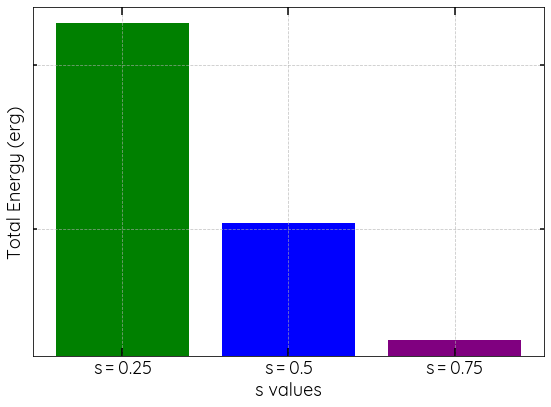

✅ Gráfica guardada en: /fs/phaethon/other0/gibran/accretion/plots/woosley/Ej>1e51_20M_W0.75_D0.2_Z0.1.pdf


In [144]:
L_jet_threshold = 1e51
# === Calcular y visualizar área y tiempo ===
# Preparar datos para gráficos
energies = []
durations = []
s_labels = []
start_times = []
end_times = []

for s in s_values:
    if str(s) in results:
        data = results[str(s)]
        times = data['times']
        L_jet_vals = data['L_jet']
        energy = np.trapz(L_jet_vals, times)
        energies.append(energy)
        above_threshold = L_jet_vals > L_jet_threshold
        if np.any(above_threshold):
            time_above = times[above_threshold]
            if len(time_above) > 0:
                start_time = time_above[0]
                end_time = time_above[-1]
                duration = end_time - start_time
                start_times.append(start_time)
                end_times.append(end_time)
                durations.append(duration)
            else:
                start_times.append(np.nan)
                end_times.append(np.nan)
                durations.append(np.nan)
        else:
            start_times.append(np.nan)
            end_times.append(np.nan)
            durations.append(np.nan)
        s_labels.append(f'$s={s}$')

# Imprimir resultados en inglés
print("\nResults for all values of s:")
for s, energy, start_t, end_t, dur in zip(s_values, energies, start_times, end_times, durations):
    if not np.isnan(dur):
        print(f"s = {s}: Total energy = {energy:.2e} erg, "
              f"Time > 1e51 erg: {start_t:.2f} s to {end_t:.2f} s, "
              f"duration = {dur:.2f} s")
    else:
        print(f"s = {s}: Total energy = {energy:.2e} erg, "
              f"Threshold of 1e51 erg not exceeded")

# === Visualización gráfica ===
# Gráfico 1: Energía total por s
plt.figure(figsize=(8, 6))
plt.bar(s_labels, energies, color=colors[:len(s_values)])
plt.xlabel('s values', fontsize=18)
plt.ylabel('Total Energy (erg)', fontsize=18)
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Configurar ticks para energía
ax = plt.gca()
ax.tick_params(axis='both', which='both', top=True, bottom=True, left=True, right=True, direction='in')
ax.tick_params(which='both', width=1.5)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=4)
ax.yaxis.set_major_locator(LogLocator(base=10, numticks=10))
ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))

plt.tight_layout()
output_file = os.path.join(output_path, f'Ej>1e51_{model}.pdf')
#plt.savefig(output_file, format='pdf')
plt.show()
print(f"✅ Gráfica guardada en: {output_file}")


In [145]:
# Convertir M_BH_crit a gramos
M_BH0 = M_BH_crit * M_sun  # Masa inicial del agujero negro en gramos

# === Cargar DataFrame y obtener R_max ===
# Asegúrate de que df esté definido previamente
df = pd.read_csv(f'Data/data_{model}.csv')
R_max = df['r'].iloc[-1]  # Radio máximo en cm

# Extraer densidad del DataFrame
radius_values = df['r'].values  # Radios en cm
rho_values = df['rho_r'].values  # Densidad en g/cm^3

# Función de interpolación de densidad con extrapolación explícita
rho_interpolated = interp1d(radius_values, rho_values, kind='cubic', bounds_error=False, fill_value=1e-5)





For s = 0.25: Breakup time = 10.87 s

For s = 0.5: Breakup time = 10.93 s

For s = 0.75: Breakup time = 10.96 s


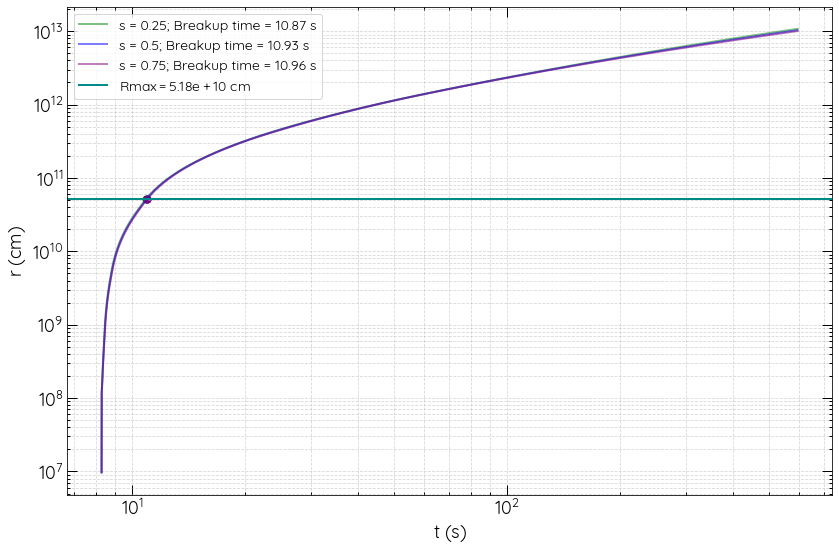

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
import os

# === Constantes físicas ===
G = 6.6726e-8    # Constante gravitacional (cm^3 g^-1 s^-2)
Msun = 1.989e33  # Masa solar (g)
Rsun = 6.957e10  # Radio solar (cm)
c = 2.9979e10    # Velocidad de la luz (cm/s)

# === Variables críticas del DataFrame ===
# Asegúrate de que closest_idx esté definido previamente
avg_teq_crit = df.loc[closest_idx, 'avg_teq']  # Tiempo crítico en segundos
r_crit = df.loc[closest_idx, 'r']             # Radio crítico en cm
M_BH_crit = df.loc[closest_idx, 'M_BH'] / Msun  # Masa del agujero negro en masas solares
a_star_crit = df.loc[closest_idx, 'a_star']    # Parámetro de espín

# Convertir M_BH_crit a gramos
M_BH0 = M_BH_crit * Msun  # Masa inicial del agujero negro en gramos

# === Cargar DataFrame y obtener R_max ===
# Asegúrate de que df esté definido previamente
df = pd.read_csv(f'Data/data_{model}.csv')
R_max = df['r'].iloc[-1]  # Radio máximo en cm

# Extraer densidad del DataFrame
radius_values = df['r'].values  # Radios en cm
rho_values = df['rho_r'].values  # Densidad en g/cm^3

# Función de interpolación de densidad con extrapolación explícita
rho_interpolated = interp1d(radius_values, rho_values, kind='linear', bounds_error=False, fill_value=1e-5)

def M_r(r):
    """Calcula la masa encerrada dentro de un radio r usando el perfil de densidad del DataFrame."""
    result, _ = quad(lambda r_prime: 4 * np.pi * r_prime**2 * rho_interpolated(r_prime), 1e6, r)
    return result

# === Iterar sobre todos los valores de s en un solo plot ===
s_values = [0.25, 0.5, 0.75]  # Ajustado según la imagen
colors = ['green', 'blue', 'purple']  # Ajustado según la imagen

plt.figure(figsize=(12, 8))

for s_target, color in zip(s_values, colors):
    if str(s_target) in results:
        data = results[str(s_target)]
        times = data['times']  # Tiempos de la simulación
        L_jet_vals = data['L_jet']  # Potencia del jet en erg/s
        t0 = avg_teq_crit  # Usar el tiempo crítico como inicio
        tf = times[-1]     # Usar el último tiempo de la simulación
        LjetF = interp1d(times, L_jet_vals, bounds_error=False, fill_value=0.0)  # Forzar valor no negativo

        # === Evolución del jet ===
        def jet_evol(gamj):
            # Condiciones iniciales
            Mbh = M_BH0  # Masa inicial del agujero negro
            Rin = 10 * G * Mbh / (c * c)  # Radio de inyección
            bj = np.sqrt(1 - 1.0 / gamj**2)  # Beta del jet
            bh0 = bj  # Beta inicial de la cabeza
            Pc = 1.0e-10  # Presión inicial del capullo
            zh0 = Rin  # Distancia inicial de la cabeza
            th0 = 1.0 / gamj  # Ángulo inicial del jet
            rc = zh0 * th0  # Radio inicial del capullo

            # Configuración de vectores con escala logarítmica
            Nt = 10000
            tvec = np.logspace(np.log10(t0), np.log10(tf), Nt)  # Escala logarítmica de tiempo
            dt = np.diff(tvec)  # Diferencias logarítmicas como pasos de tiempo
            zhvec = np.zeros(Nt)
            bhvec = np.zeros(Nt)
            L0vec = np.zeros(Nt)
            bcvec = np.zeros(Nt)
            rcvec = np.zeros(Nt)
            zcollvec = np.zeros(Nt)
            rjvec = np.zeros(Nt)

            # Inicialización
            zhvec[0] = zh = zh0
            bhvec[0] = bh = bh0
            bcvec[0] = 0.0
            rcvec[0] = rc
            L0vec[0] = 0.0
            zcollvec[0] = zcoll = 0.0
            EInj = 0.0  # Inicializar EInj aquí

            # Evolución temporal del jet
            for i in range(Nt-1):
                rho = rho_interpolated(zh)  # Usar el perfil de densidad del DataFrame
                if rho <= 0:
                    print(f"Warning: rho = {rho} at zh = {zh}, setting bc = 0 to avoid domain error")
                    bc = 0.0
                else:
                    if tvec[i] > times[-1]:
                        EInj = EInj  # Mantener energía si excede el tiempo máximo
                    else:
                        EInj += LjetF(tvec[i]) * (1 - bh) * dt[i]  # Acumulación segura
                    Pc = EInj / (3 * np.pi * rc * rc * zh)
                    bc = min(1.0, np.sqrt(Pc / (rho * c * c)))
                rc += bc * c * dt[i]
                zcoll = 0.5 * np.sqrt(LjetF(tvec[i]) * bj / (np.pi * c * Pc))
                if zh > zcoll:
                    Aj = LjetF(tvec[i]) * th0**2 / (4 * c * Pc)
                else:
                    Aj = np.pi * (zh * th0)**2
                L0 = LjetF(tvec[i]) / (Aj * rho * c * c * c)
                bh = bj / (1 + 1.0 / np.sqrt(L0))
                zh += bh * c * dt[i]

                # Actualizar vectores
                zhvec[i+1] = zh
                bhvec[i+1] = bh
                L0vec[i+1] = L0
                bcvec[i+1] = bc
                rcvec[i+1] = rc
                zcollvec[i+1] = zcoll
                rjvec[i+1] = np.sqrt(Aj / np.pi)

            return tvec, zhvec, L0vec, bhvec, bcvec, zcollvec, rjvec, rcvec

        # Ejecutar la evolución para este s
        gamma_j = 10.0  # Factor de Lorentz inicial
        Mat = jet_evol(gamma_j)
        tvec, zhvec, L0vec, bhvec, bcvec, zcollvec, rjvec, rcvec = Mat

        # Calcular breakup time como el tiempo cuando zh >= R_max
        breakup_time = np.interp(R_max, zhvec, tvec) if R_max <= max(zhvec) else np.nan
        print(f"\nFor s = {s_target}: Breakup time = {breakup_time:.2f} s")

        # Graficar resultados en un solo plot
        plt.scatter([breakup_time], [R_max], color=color, s=50)
        plt.loglog(tvec, zhvec, label=f's = {s_target}; Breakup time = {breakup_time:.2f} s', 
                   color=color, linewidth=2.0, alpha=0.5)

plt.axhline(y=R_max, color='darkcyan', linewidth = 2.0, linestyle='-', label=r'$Rmax = {:.2e}$ cm'.format(R_max))
plt.xlabel(r'$t$ (s)', fontsize=18)  
plt.ylabel(r'$r$ (cm)', fontsize=18)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(fontsize=14)

# Configurar ticks
ax = plt.gca()
ax.tick_params(axis='both', which='both', top=True, bottom=True, left=True, right=True, direction='in')
ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=3)
ax.xaxis.set_major_locator(LogLocator(base=10, numticks=10))
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
ax.yaxis.set_major_locator(LogLocator(base=10, numticks=10))
ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))

plt.tight_layout()
output_file_individual = os.path.join(output_path, f'Breakup_{model}.pdf')
plt.savefig(output_file_individual, format='pdf')
plt.show()

In [147]:
# Definir factores de eficiencia del medio (10%, 50%, 100%)
efficiency_factors = [0.01, 0.1, 0.5, 1.0]
efficiency_labels = ['1%','10%', '50%', '100%']


for s_target, color in zip(s_values, colors):
    if str(s_target) in results:
        data = results[str(s_target)]
        times = data['times']  # Tiempos de la simulación
        L_jet_vals = data['L_jet']  # Potencia del jet en erg/s
        t0 = avg_teq_crit  # Usar el tiempo crítico como inicio
        tf = times[-1]     # Usar el último tiempo de la simulación
        LjetF = interp1d(times, L_jet_vals, bounds_error=False, fill_value=0.0)  # Forzar valor no negativo

        # === Evolución del jet con control de eficiencia ===
        def jet_evol(gamj, efficiency_factor):
            # Condiciones iniciales
            Mbh = M_BH0  # Masa inicial del agujero negro
            Rin = 10 * G * Mbh / (c * c)  # Radio de inyección
            bj = np.sqrt(1 - 1.0 / gamj**2)  # Beta del jet
            bh0 = bj  # Beta inicial de la cabeza
            Pc = 1.0e-10  # Presión inicial del capullo
            zh0 = Rin  # Distancia inicial de la cabeza
            th0 = 1.0 / gamj  # Ángulo inicial del jet
            rc = zh0 * th0  # Radio inicial del capullo

            # Configuración de vectores
            Nt = 10000
            dt = 1.0 * (tf - t0) / Nt  

            tvec = np.empty(Nt)
            zhvec = np.empty(Nt)
            bhvec = np.empty(Nt)
            L0vec = np.empty(Nt)
            bcvec = np.empty(Nt)
            rcvec = np.empty(Nt)
            zcollvec = np.empty(Nt)
            rjvec = np.empty(Nt)

            # Inicialización
            zhvec[0] = zh = zh0
            bhvec[0] = bh = bh0
            bcvec[0] = 0.0
            rcvec[0] = rc
            tvec[0] = t0  # Iniciar desde el tiempo crítico
            L0vec[0] = 0.0
            zcollvec[0] = zcoll = 0.0

            t = tvec[0]
            EInj = 0.0  # Energía inicial inyectada

            # Evolución temporal del jet
            for i in range(Nt-1):
                rho = efficiency_factor * rho_interpolated(zh) 
                if rho <= 0:
                    print(f"Warning: rho = {rho} at zh = {zh}, setting bc = 0 to avoid domain error")
                    bc = 0.0
                else:
                    t += dt
                    if t > times[-1]:
                        EInj += 0.0 
                    else:
                        EInj += LjetF(t) * (1 - bh) * dt
                    Pc = EInj / (3 * np.pi * rc * rc * zh)
                    bc = min(1.0, np.sqrt(Pc / (rho * c * c)))
                rc += bc * c * dt
                zcoll = 0.5 * np.sqrt(LjetF(t) * bj / (np.pi * c * Pc))
                if zh > zcoll:
                    Aj = LjetF(t) * th0**2 / (4 * c * Pc)
                else:
                    Aj = np.pi * (zh * th0)**2
                L0 = LjetF(t) / (Aj * rho * c * c * c)
                bh = bj / (1 + 1.0 / np.sqrt(L0))
                zh += bh * c * dt

                # Actualizar vectores
                tvec[i+1] = t
                zhvec[i+1] = zh
                bhvec[i+1] = bh
                L0vec[i+1] = L0
                bcvec[i+1] = bc
                rcvec[i+1] = rc
                zcollvec[i+1] = zcoll
                rjvec[i] = np.sqrt(Aj / np.pi)

            return tvec, zhvec, L0vec, bhvec, bcvec, zcollvec, rjvec, rcvec

        # Ejecutar la evolución para este s con diferentes eficiencias
        for eff_factor, eff_label in zip(efficiency_factors, efficiency_labels):
            Mat = jet_evol(gamma_j, eff_factor)
            tvec, zhvec, L0vec, bhvec, bcvec, zcollvec, rjvec, rcvec = Mat

            # Calcular breakup time como el tiempo cuando zh >= R_max
            breakup_time = np.interp(R_max, zhvec, tvec) if R_max <= max(zhvec) else np.nan
            print(f"\nFor s = {s_target}, efficiency = {eff_label}: Breakup time = {breakup_time:.2f} s")

           


For s = 0.25, efficiency = 1%: Breakup time = 10.39 s

For s = 0.25, efficiency = 10%: Breakup time = 10.73 s

For s = 0.25, efficiency = 50%: Breakup time = 11.14 s

For s = 0.25, efficiency = 100%: Breakup time = 11.38 s

For s = 0.5, efficiency = 1%: Breakup time = 10.41 s

For s = 0.5, efficiency = 10%: Breakup time = 10.78 s

For s = 0.5, efficiency = 50%: Breakup time = 11.22 s

For s = 0.5, efficiency = 100%: Breakup time = 11.47 s

For s = 0.75, efficiency = 1%: Breakup time = 10.43 s

For s = 0.75, efficiency = 10%: Breakup time = 10.82 s

For s = 0.75, efficiency = 50%: Breakup time = 11.27 s

For s = 0.75, efficiency = 100%: Breakup time = 11.53 s


/tmp/ipykernel_137187/4150741278.py:108: RuntimeWarning: invalid value encountered in sqrt
  bh = bj / (1 + 1.0 / np.sqrt(L0))



For s = 0.25: Breakup time = nan s

For s = 0.5: Breakup time = nan s

For s = 0.75: Breakup time = nan s


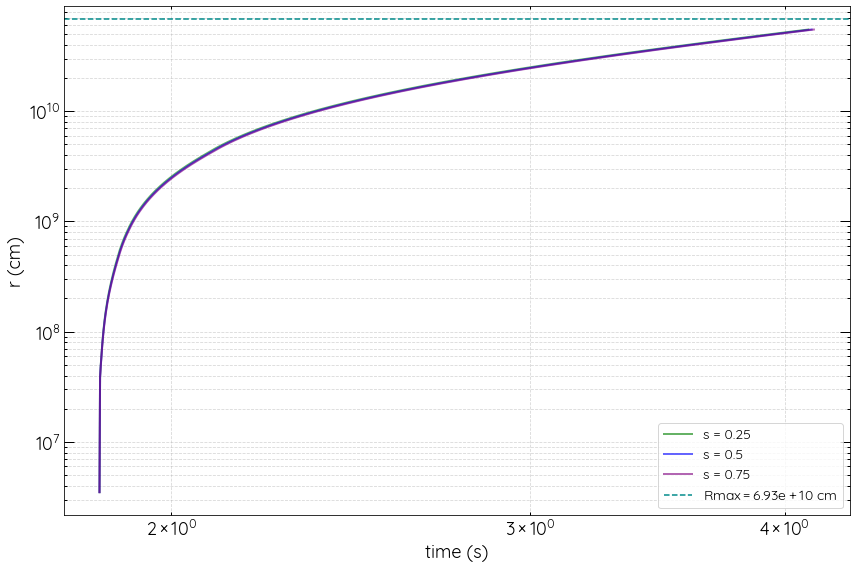

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
import os

# === Constantes físicas ===
G = 6.6726e-8    # Constante gravitacional (cm^3 g^-1 s^-2)
Msun = 1.989e33  # Masa solar (g)
Rsun = 6.957e10  # Radio solar (cm)
c = 2.9979e10    # Velocidad de la luz (cm/s)

# === Variables críticas del DataFrame ===
# Asegúrate de que closest_idx esté definido previamente
avg_teq_crit = df.loc[closest_idx, 'avg_teq']  # Tiempo crítico en segundos
r_crit = df.loc[closest_idx, 'r']             # Radio crítico en cm
M_BH_crit = df.loc[closest_idx, 'M_BH'] / Msun  # Masa del agujero negro en masas solares
a_star_crit = df.loc[closest_idx, 'a_star']    # Parámetro de espín

# Convertir M_BH_crit a gramos
M_BH0 = M_BH_crit * Msun  # Masa inicial del agujero negro en gramos

# === Cargar DataFrame y obtener R_max ===
# Asegúrate de que df esté definido previamente
df = pd.read_csv(f'Data/data_{model}.csv')
R_max = df['r'].iloc[-1]  # Radio máximo en cm

# Extraer densidad del DataFrame
radius_values = df['r'].values  # Radios en cm
rho_values = df['rho_r'].values  # Densidad en g/cm^3

# Función de interpolación de densidad con extrapolación explícita
rho_interpolated = interp1d(radius_values, rho_values, kind='cubic', bounds_error=False, fill_value=1e-5)

def M_r(r):
    """Calcula la masa encerrada dentro de un radio r usando el perfil de densidad del DataFrame."""
    result, _ = quad(lambda r_prime: 4 * np.pi * r_prime**2 * rho_interpolated(r_prime), 1e6, r)
    return result

# === Iterar sobre todos los valores de s en un solo plot ===
s_values = [0.25, 0.5, 0.75]  # Ajustado según la imagen
colors = ['green', 'blue', 'purple']  # Ajustado según la imagen

plt.figure(figsize=(12, 8))

for s_target, color in zip(s_values, colors):
    if str(s_target) in results:
        data = results[str(s_target)]
        times = data['times']  # Tiempos de la simulación
        L_jet_vals = data['L_jet']  # Potencia del jet en erg/s
        t0 = avg_teq_crit  # Usar el tiempo crítico como inicio
        tf = times[-1]     # Usar el último tiempo de la simulación
        LjetF = interp1d(times, L_jet_vals, bounds_error=False, fill_value=0.0)  # Forzar valor no negativo

        # === Evolución del jet ===
        def jet_evol(gamj):
            # Condiciones iniciales
            Mbh = M_BH0  # Masa inicial del agujero negro
            Rin = 10 * G * Mbh / (c * c)  # Radio de inyección
            bj = np.sqrt(1 - 1.0 / gamj**2)  # Beta del jet
            bh0 = bj  # Beta inicial de la cabeza
            Pc = 1.0e-10  # Presión inicial del capullo
            zh0 = Rin  # Distancia inicial de la cabeza
            th0 = 1.0 / gamj  # Ángulo inicial del jet
            rc = zh0 * th0  # Radio inicial del capullo

            # Configuración de vectores con escala logarítmica
            Nt = 10000
            tvec = np.logspace(np.log10(t0), np.log10(tf), Nt)  # Escala logarítmica de tiempo
            dt = np.diff(tvec)  # Diferencias logarítmicas como pasos de tiempo
            zhvec = np.zeros(Nt)
            bhvec = np.zeros(Nt)
            L0vec = np.zeros(Nt)
            bcvec = np.zeros(Nt)
            rcvec = np.zeros(Nt)
            zcollvec = np.zeros(Nt)
            rjvec = np.zeros(Nt)

            # Inicialización
            zhvec[0] = zh = zh0
            bhvec[0] = bh = bh0
            bcvec[0] = 0.0
            rcvec[0] = rc
            L0vec[0] = 0.0
            zcollvec[0] = zcoll = 0.0
            EInj = 0.0  # Inicializar EInj aquí

            # Evolución temporal del jet
            for i in range(Nt-1):
                rho = rho_interpolated(zh)  # Usar el perfil de densidad del DataFrame
                if rho <= 0:
                    print(f"Warning: rho = {rho} at zh = {zh}, setting bc = 0 to avoid domain error")
                    bc = 0.0
                else:
                    if tvec[i] > times[-1]:
                        EInj = EInj  # Mantener energía si excede el tiempo máximo
                    else:
                        EInj += LjetF(tvec[i]) * (1 - bh) * dt[i]  # Acumulación segura
                    Pc = EInj / (3 * np.pi * rc * rc * zh)
                    bc = min(1.0, np.sqrt(Pc / (rho * c * c)))
                rc += bc * c * dt[i]
                zcoll = 0.5 * np.sqrt(LjetF(tvec[i]) * bj / (np.pi * c * Pc))
                if zh > zcoll:
                    Aj = LjetF(tvec[i]) * th0**2 / (4 * c * Pc)
                else:
                    Aj = np.pi * (zh * th0)**2
                L0 = LjetF(tvec[i]) / (Aj * rho * c * c * c)
                bh = bj / (1 + 1.0 / np.sqrt(L0))
                zh += bh * c * dt[i]

                # Actualizar vectores
                zhvec[i+1] = zh
                bhvec[i+1] = bh
                L0vec[i+1] = L0
                bcvec[i+1] = bc
                rcvec[i+1] = rc
                zcollvec[i+1] = zcoll
                rjvec[i+1] = np.sqrt(Aj / np.pi)

            return tvec, zhvec, L0vec, bhvec, bcvec, zcollvec, rjvec, rcvec

        # Ejecutar la evolución para este s
        gamma_j = 10.0  # Factor de Lorentz inicial
        Mat = jet_evol(gamma_j)
        tvec, zhvec, L0vec, bhvec, bcvec, zcollvec, rjvec, rcvec = Mat

        # Calcular breakup time como el tiempo cuando zh >= R_max
        breakup_time = np.interp(R_max, zhvec, tvec) if R_max <= max(zhvec) else np.nan
        print(f"\nFor s = {s_target}: Breakup time = {breakup_time:.2f} s")

        # Graficar resultados en un solo plot
        plt.scatter([breakup_time], [R_max], color=color, s=50)
        plt.loglog(tvec, zhvec, label=f's = {s_target}', color=color, linewidth=2.0, alpha=0.6)  # Curva de fondo

plt.axhline(y=R_max, color='darkcyan', linestyle='--', label=r'$Rmax = {:.2e}$ cm'.format(R_max))
plt.xlabel(r'time (s)', fontsize=18)
plt.ylabel(r'r (cm)', fontsize=18)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(fontsize=14)

# Configurar ticks
ax = plt.gca()
ax.tick_params(axis='both', which='both', top=True, bottom=True, left=True, right=True, direction='in')
ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=3)
ax.xaxis.set_major_locator(LogLocator(base=10, numticks=10))
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
ax.yaxis.set_major_locator(LogLocator(base=10, numticks=10))
ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))

plt.tight_layout()
output_file_individual = os.path.join(output_path, f'Breakup_{model}.pdf')
#plt.savefig(output_file_individual, format='pdf')
plt.show()

/tmp/ipykernel_137187/2640205803.py:108: RuntimeWarning: invalid value encountered in sqrt
  bh = bj / (1 + 1.0 / np.sqrt(L0))



For s = 0.25: Breakup time = nan s

For s = 0.5: Breakup time = nan s

For s = 0.75: Breakup time = nan s


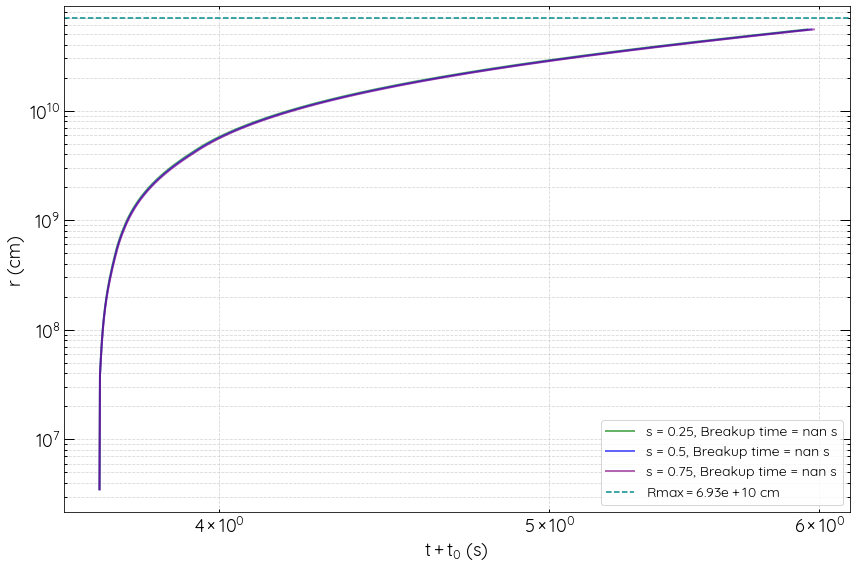

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
import os

# === Constantes físicas ===
G = 6.6726e-8    # Constante gravitacional (cm^3 g^-1 s^-2)
Msun = 1.989e33  # Masa solar (g)
Rsun = 6.957e10  # Radio solar (cm)
c = 2.9979e10    # Velocidad de la luz (cm/s)

# === Variables críticas del DataFrame ===
# Asegúrate de que closest_idx esté definido previamente
avg_teq_crit = df.loc[closest_idx, 'avg_teq']  # Tiempo crítico en segundos
r_crit = df.loc[closest_idx, 'r']             # Radio crítico en cm
M_BH_crit = df.loc[closest_idx, 'M_BH'] / Msun  # Masa del agujero negro en masas solares
a_star_crit = df.loc[closest_idx, 'a_star']    # Parámetro de espín

# Convertir M_BH_crit a gramos
M_BH0 = M_BH_crit * Msun  # Masa inicial del agujero negro en gramos

# === Cargar DataFrame y obtener R_max ===
# Asegúrate de que df esté definido previamente
df = pd.read_csv(f'Data/data_{model}.csv')
R_max = df['r'].iloc[-1]  # Radio máximo en cm

# Extraer densidad del DataFrame
radius_values = df['r'].values  # Radios en cm
rho_values = df['rho_r'].values  # Densidad en g/cm^3

# Función de interpolación de densidad con extrapolación explícita
rho_interpolated = interp1d(radius_values, rho_values, kind='cubic', bounds_error=False, fill_value=1e-5)

def M_r(r):
    """Calcula la masa encerrada dentro de un radio r usando el perfil de densidad del DataFrame."""
    result, _ = quad(lambda r_prime: 4 * np.pi * r_prime**2 * rho_interpolated(r_prime), 1e6, r)
    return result

# === Iterar sobre todos los valores de s en un solo plot ===
s_values = [0.25, 0.5, 0.75]  # Ajustado según la imagen
colors = ['green', 'blue', 'purple']  # Ajustado según la imagen

plt.figure(figsize=(12, 8))

for s_target, color in zip(s_values, colors):
    if str(s_target) in results:
        data = results[str(s_target)]
        times = data['times']  # Tiempos de la simulación
        L_jet_vals = data['L_jet']  # Potencia del jet en erg/s
        t0 = avg_teq_crit  # Usar el tiempo crítico como inicio
        tf = times[-1]     # Usar el último tiempo de la simulación
        LjetF = interp1d(times, L_jet_vals, bounds_error=False, fill_value=0.0)  # Forzar valor no negativo

        # === Evolución del jet ===
        def jet_evol(gamj):
            # Condiciones iniciales
            Mbh = M_BH0  # Masa inicial del agujero negro
            Rin = 10 * G * Mbh / (c * c)  # Radio de inyección
            bj = np.sqrt(1 - 1.0 / gamj**2)  # Beta del jet
            bh0 = bj  # Beta inicial de la cabeza
            Pc = 1.0e-10  # Presión inicial del capullo
            zh0 = Rin  # Distancia inicial de la cabeza
            th0 = 1.0 / gamj  # Ángulo inicial del jet
            rc = zh0 * th0  # Radio inicial del capullo

            # Configuración de vectores con escala logarítmica
            Nt = 10000
            tvec = np.logspace(np.log10(t0), np.log10(tf), Nt)  # Escala logarítmica de tiempo
            dt = np.diff(tvec)  # Diferencias logarítmicas como pasos de tiempo
            zhvec = np.zeros(Nt)
            bhvec = np.zeros(Nt)
            L0vec = np.zeros(Nt)
            bcvec = np.zeros(Nt)
            rcvec = np.zeros(Nt)
            zcollvec = np.zeros(Nt)
            rjvec = np.zeros(Nt)

            # Inicialización
            zhvec[0] = zh = zh0
            bhvec[0] = bh = bh0
            bcvec[0] = 0.0
            rcvec[0] = rc
            L0vec[0] = 0.0
            zcollvec[0] = zcoll = 0.0
            EInj = 0.0  # Inicializar EInj aquí

            # Evolución temporal del jet
            for i in range(Nt-1):
                rho = rho_interpolated(zh)  # Usar el perfil de densidad del DataFrame
                if rho <= 0:
                    print(f"Warning: rho = {rho} at zh = {zh}, setting bc = 0 to avoid domain error")
                    bc = 0.0
                else:
                    if tvec[i] > times[-1]:
                        EInj = EInj  # Mantener energía si excede el tiempo máximo
                    else:
                        EInj += LjetF(tvec[i]) * (1 - bh) * dt[i]  # Acumulación segura
                    Pc = EInj / (3 * np.pi * rc * rc * zh)
                    bc = min(1.0, np.sqrt(Pc / (rho * c * c)))
                rc += bc * c * dt[i]
                zcoll = 0.5 * np.sqrt(LjetF(tvec[i]) * bj / (np.pi * c * Pc))
                if zh > zcoll:
                    Aj = LjetF(tvec[i]) * th0**2 / (4 * c * Pc)
                else:
                    Aj = np.pi * (zh * th0)**2
                L0 = LjetF(tvec[i]) / (Aj * rho * c * c * c)
                bh = bj / (1 + 1.0 / np.sqrt(L0))
                zh += bh * c * dt[i]

                # Actualizar vectores
                zhvec[i+1] = zh
                bhvec[i+1] = bh
                L0vec[i+1] = L0
                bcvec[i+1] = bc
                rcvec[i+1] = rc
                zcollvec[i+1] = zcoll
                rjvec[i+1] = np.sqrt(Aj / np.pi)

            return tvec, zhvec, L0vec, bhvec, bcvec, zcollvec, rjvec, rcvec

        # Ejecutar la evolución para este s
        gamma_j = 10.0  # Factor de Lorentz inicial
        Mat = jet_evol(gamma_j)
        tvec, zhvec, L0vec, bhvec, bcvec, zcollvec, rjvec, rcvec = Mat

        # Calcular breakup time como el tiempo cuando zh >= R_max
        breakup_time = np.interp(R_max, zhvec, tvec) if R_max <= max(zhvec) else np.nan
        print(f"\nFor s = {s_target}: Breakup time = {breakup_time:.2f} s")

        # Graficar resultados en un solo plot con desplazamiento t + t0
        tvec_shifted = tvec + t0  # Desplazar el tiempo para mostrar t + t0
        plt.scatter([breakup_time + t0], [R_max], color=color, s=50)  # Ajustar scatter
        plt.loglog(tvec_shifted, zhvec, label=f's = {s_target}, Breakup time = {breakup_time:.2f} s', 
                   color=color, linewidth=2.0, alpha=0.6)  # Añadir breakup time a la leyenda

plt.axhline(y=R_max, color='darkcyan', linestyle='--', label=r'$Rmax = {:.2e}$ cm'.format(R_max))
plt.xlabel(r'$t + t_0$ (s)', fontsize=18)  # Cambiar etiqueta del eje x
plt.ylabel(r'r (cm)', fontsize=18)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(fontsize=14)

# Configurar ticks
ax = plt.gca()
ax.tick_params(axis='both', which='both', top=True, bottom=True, left=True, right=True, direction='in')
ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=3)
ax.xaxis.set_major_locator(LogLocator(base=10, numticks=10))
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
ax.yaxis.set_major_locator(LogLocator(base=10, numticks=10))
ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))

plt.tight_layout()
output_file_individual = os.path.join(output_path, f'Breakup_{model}.pdf')
#plt.savefig(output_file_individual, format='pdf')
plt.show()

/tmp/ipykernel_137187/1394701509.py:108: RuntimeWarning: invalid value encountered in sqrt
  bh = bj / (1 + 1.0 / np.sqrt(L0))



For s = 0.25: Breakup time = nan s

For s = 0.5: Breakup time = nan s

For s = 0.75: Breakup time = nan s


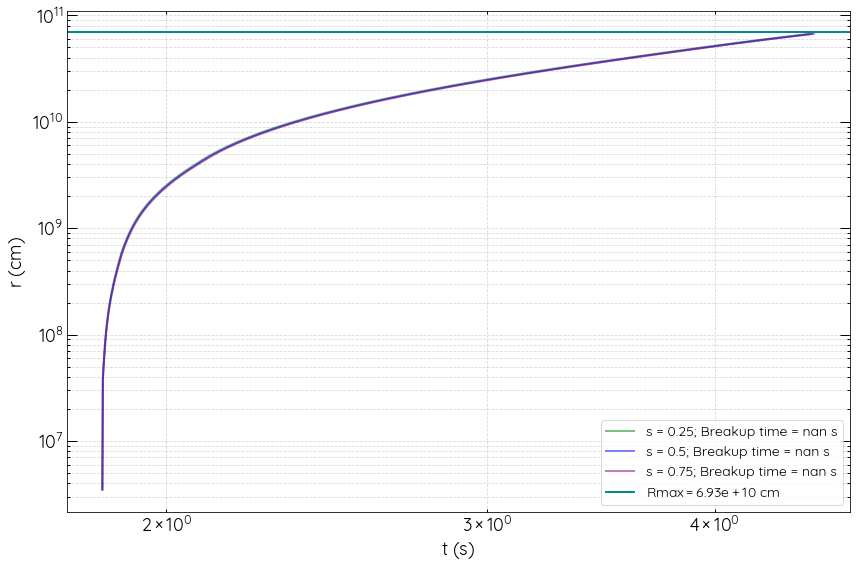

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
import os

# === Constantes físicas ===
G = 6.6726e-8    # Constante gravitacional (cm^3 g^-1 s^-2)
Msun = 1.989e33  # Masa solar (g)
Rsun = 6.957e10  # Radio solar (cm)
c = 2.9979e10    # Velocidad de la luz (cm/s)

# === Variables críticas del DataFrame ===
# Asegúrate de que closest_idx esté definido previamente
avg_teq_crit = df.loc[closest_idx, 'avg_teq']  # Tiempo crítico en segundos
r_crit = df.loc[closest_idx, 'r']             # Radio crítico en cm
M_BH_crit = df.loc[closest_idx, 'M_BH'] / Msun  # Masa del agujero negro en masas solares
a_star_crit = df.loc[closest_idx, 'a_star']    # Parámetro de espín

# Convertir M_BH_crit a gramos
M_BH0 = M_BH_crit * Msun  # Masa inicial del agujero negro en gramos

# === Cargar DataFrame y obtener R_max ===
# Asegúrate de que df esté definido previamente
df = pd.read_csv(f'Data/data_{model}.csv')
R_max = df['r'].iloc[-1]  # Radio máximo en cm

# Extraer densidad del DataFrame
radius_values = df['r'].values  # Radios en cm
rho_values = df['rho_r'].values  # Densidad en g/cm^3

# Función de interpolación de densidad con extrapolación explícita
rho_interpolated = interp1d(radius_values, rho_values, kind='linear', bounds_error=False, fill_value=1e-5)

def M_r(r):
    """Calcula la masa encerrada dentro de un radio r usando el perfil de densidad del DataFrame."""
    result, _ = quad(lambda r_prime: 4 * np.pi * r_prime**2 * rho_interpolated(r_prime), 1e6, r)
    return result

# === Iterar sobre todos los valores de s en un solo plot ===
s_values = [0.25, 0.5, 0.75]  # Ajustado según la imagen
colors = ['green', 'blue', 'purple']  # Ajustado según la imagen

plt.figure(figsize=(12, 8))

for s_target, color in zip(s_values, colors):
    if str(s_target) in results:
        data = results[str(s_target)]
        times = data['times']  # Tiempos de la simulación
        L_jet_vals = data['L_jet']  # Potencia del jet en erg/s
        t0 = avg_teq_crit  # Usar el tiempo crítico como inicio
        tf = times[-1]     # Usar el último tiempo de la simulación
        LjetF = interp1d(times, L_jet_vals, bounds_error=False, fill_value=0.0)  # Forzar valor no negativo

        # === Evolución del jet ===
        def jet_evol(gamj):
            # Condiciones iniciales
            Mbh = M_BH0  # Masa inicial del agujero negro
            Rin = 10 * G * Mbh / (c * c)  # Radio de inyección
            bj = np.sqrt(1 - 1.0 / gamj**2)  # Beta del jet
            bh0 = bj  # Beta inicial de la cabeza
            Pc = 1.0e-10  # Presión inicial del capullo
            zh0 = Rin  # Distancia inicial de la cabeza
            th0 = 1.0 / gamj  # Ángulo inicial del jet
            rc = zh0 * th0  # Radio inicial del capullo

            # Configuración de vectores con escala logarítmica
            Nt = 10000
            tvec = np.logspace(np.log10(t0), np.log10(tf), Nt)  # Escala logarítmica de tiempo
            dt = np.diff(tvec)  # Diferencias logarítmicas como pasos de tiempo
            zhvec = np.zeros(Nt)
            bhvec = np.zeros(Nt)
            L0vec = np.zeros(Nt)
            bcvec = np.zeros(Nt)
            rcvec = np.zeros(Nt)
            zcollvec = np.zeros(Nt)
            rjvec = np.zeros(Nt)

            # Inicialización
            zhvec[0] = zh = zh0
            bhvec[0] = bh = bh0
            bcvec[0] = 0.0
            rcvec[0] = rc
            L0vec[0] = 0.0
            zcollvec[0] = zcoll = 0.0
            EInj = 0.0  # Inicializar EInj aquí

            # Evolución temporal del jet
            for i in range(Nt-1):
                rho = rho_interpolated(zh)  # Usar el perfil de densidad del DataFrame
                if rho <= 0:
                    print(f"Warning: rho = {rho} at zh = {zh}, setting bc = 0 to avoid domain error")
                    bc = 0.0
                else:
                    if tvec[i] > times[-1]:
                        EInj = EInj  # Mantener energía si excede el tiempo máximo
                    else:
                        EInj += LjetF(tvec[i]) * (1 - bh) * dt[i]  # Acumulación segura
                    Pc = EInj / (3 * np.pi * rc * rc * zh)
                    bc = min(1.0, np.sqrt(Pc / (rho * c * c)))
                rc += bc * c * dt[i]
                zcoll = 0.5 * np.sqrt(LjetF(tvec[i]) * bj / (np.pi * c * Pc))
                if zh > zcoll:
                    Aj = LjetF(tvec[i]) * th0**2 / (4 * c * Pc)
                else:
                    Aj = np.pi * (zh * th0)**2
                L0 = LjetF(tvec[i]) / (Aj * rho * c * c * c)
                bh = bj / (1 + 1.0 / np.sqrt(L0))
                zh += bh * c * dt[i]

                # Actualizar vectores
                zhvec[i+1] = zh
                bhvec[i+1] = bh
                L0vec[i+1] = L0
                bcvec[i+1] = bc
                rcvec[i+1] = rc
                zcollvec[i+1] = zcoll
                rjvec[i+1] = np.sqrt(Aj / np.pi)

            return tvec, zhvec, L0vec, bhvec, bcvec, zcollvec, rjvec, rcvec

        # Ejecutar la evolución para este s
        gamma_j = 10.0  # Factor de Lorentz inicial
        Mat = jet_evol(gamma_j)
        tvec, zhvec, L0vec, bhvec, bcvec, zcollvec, rjvec, rcvec = Mat

        # Calcular breakup time como el tiempo cuando zh >= R_max
        breakup_time = np.interp(R_max, zhvec, tvec) if R_max <= max(zhvec) else np.nan
        print(f"\nFor s = {s_target}: Breakup time = {breakup_time:.2f} s")

        # Graficar resultados en un solo plot
        plt.scatter([breakup_time], [R_max], color=color, s=50)
        plt.loglog(tvec, zhvec, label=f's = {s_target}; Breakup time = {breakup_time:.2f} s', 
                   color=color, linewidth=2.0, alpha=0.5)

plt.axhline(y=R_max, color='darkcyan', linewidth = 2.0, linestyle='-', label=r'$Rmax = {:.2e}$ cm'.format(R_max))
plt.xlabel(r'$t$ (s)', fontsize=18)  
plt.ylabel(r'$r$ (cm)', fontsize=18)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend(fontsize=14)

# Configurar ticks
ax = plt.gca()
ax.tick_params(axis='both', which='both', top=True, bottom=True, left=True, right=True, direction='in')
ax.tick_params(which='both', width=1)
ax.tick_params(which='major', length=10)
ax.tick_params(which='minor', length=3)
ax.xaxis.set_major_locator(LogLocator(base=10, numticks=10))
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))
ax.yaxis.set_major_locator(LogLocator(base=10, numticks=10))
ax.yaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(2, 10)))

plt.tight_layout()
output_file_individual = os.path.join(output_path, f'Breakup_{model}.pdf')
plt.savefig(output_file_individual, format='pdf')
plt.show()